# NLP Capstone - Sentiment Analysis on Airline Tweets

#### Author: Will Becerra
#### Email: willbecerra@yahoo.com

#### Date: October 27, 2018

## Introduction

Twitter is an American online news and social networking service on which users post and interact with messages known as "tweets".  Users share these tweets with other twitter users who interact by responding and retweeting.  Founded in 2006, by 2012, more than 100 million users posted 340 million tweets a day and as of February 2018, the social network had over 330 million active monthly users.

With brand awareness being so important in a company's social media strategy, I wanted to use the NLP techniques I've developed to analyze and predict sentiment of a tweet based on its text.  The data set I chose included 14,640 tweets with 15 features for 6 US Airlines

Summary:

I found there are certain key words that show up again and again for both negative and positive tweets.  Lemmatization produced the best predictive model.

Business Importance:
- Airlines can set triggers for negative keywords using real-time scraping.  If they hit a certain threshold, take a business action.
- Customer service was one of the biggest causes for negative sentiment.  Investing dollars in improving customer service could improve brand good will.
- NLP gives insights on company as well as competitors strengths and weaknesses.  Changes over time can show where competitors are strategically investing.

The accuracy I can predict with the strongest model is 78%.

In [902]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import re
import sklearn
import string

import nltk
nltk.download('punkt')
nltk.download('wordnet')

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import PorterStemmer, SnowballStemmer
from unidecode import unidecode
import emoji
from emoji.unicode_codes import UNICODE_EMOJI
from wordcloud import WordCloud
stops = stopwords.words('english')

# Handling imbalance
from imblearn.over_sampling import SMOTE

# Standardization
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Decision tree
from sklearn import tree
# Packages for rendering trees.
import pydotplus
import graphviz

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Ridge Regression
from sklearn.linear_model import RidgeClassifier

# Random Forest
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Boosting
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Support Vectors
from sklearn import svm

from sklearn.model_selection import GridSearchCV

from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics.pairwise import cosine_similarity

import time

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Will\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Will\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [903]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Import Data and create DataFrame

In [904]:
df = pd.read_csv('tweets.csv')

In [905]:
df.shape

(14640, 15)

### Our data has 14,640 tweets and 15 features for each.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Check for missing values

In [4]:
df.isnull().sum()/len(df)*100

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

In [7]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


## Let's look at how many messages were retweeted

In [8]:
df.retweet_count.value_counts()

0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
9         1
31        1
18        1
15        1
28        1
44        1
11        1
Name: retweet_count, dtype: int64

## Let's see the Top 5 retweeted tweets

In [565]:
# Retweets

tweet_df = df.sort_values(by='retweet_count', ascending=False)
tweet_df = tweet_df.reset_index(drop=True)
print('Mean retweets:', round(tweet_df['retweet_count'].mean(),2)), '\n'
print('Top 5 retweeted tweets:')
print('------------------')
for i in range(5):
    print(tweet_df['text'].loc[i], '-', tweet_df['retweet_count'].loc[i]) 
    print('\n')

Mean retweets: 0.08
Top 5 retweeted tweets:
------------------
@USAirways 5 hr flight delay and a delay when we land . Is that even real life ? Get me off this plane , I wanna go home 👠👠👠 (3 heel clicks) - 44


@USAirways of course never again tho . Thanks for tweetin ur concern but not Doin anythin to fix what happened. I'll choose wiser next time - 32


STOP. USING.THIS.WORD. IF. YOU'RE. A. COMPANY. RT @JetBlue: Our fleet's on fleek. http://t.co/Fd2TNYcTrB - 31


@USAirways with this livery back in the day. http://t.co/EEqWVAMmiy - 28


@SouthwestAir beautiful day in Seattle! http://t.co/iqu0PPVq2S - 22




## Let's also take a look at the Top 10 hashtags and mentions

In [572]:
import operator

# Hashtags & mentions
tag_dict = {}
mention_dict = {}

for i in tweet_df.index:
    tweet_text = tweet_df.loc[i]['text']
    tweet = tweet_text.lower()
    tweet_tokenized = tweet.split()

    for word in tweet_tokenized:
        # Hashtags - tokenize and build dict of tag counts
        if (word[0:1] == '#' and len(word) > 1):
            key = word.translate(str.maketrans("","", string.punctuation))
            if key in tag_dict:
                tag_dict[key] += 1
            else:
                tag_dict[key] = 1

        # Mentions - tokenize and build dict of mention counts
        if (word[0:1] == '@' and len(word) > 1):
            key = word.translate(str.maketrans("","", string.punctuation))
            if key in mention_dict:
                mention_dict[key] += 1
            else:
                mention_dict[key] = 1

# The 10 most popular tags and counts
top_tags = dict(sorted(tag_dict.items(), key=operator.itemgetter(1), reverse=True)[:10])
top_tags_sorted = sorted(top_tags.items(), key=lambda x: x[1])[::-1]
print('Top 10 hashtags:')
print('----------------')
for tag in top_tags_sorted:
    print(tag[0], '-', str(tag[1]))
    
# The 10 most popular mentions and counts
top_mentions = dict(sorted(mention_dict.items(), key=operator.itemgetter(1), reverse=True)[:10])
top_mentions_sorted = sorted(top_mentions.items(), key=lambda x: x[1])[::-1]
print('\nTop 10 mentions:')
print('----------------')
for mention in top_mentions_sorted:
    print(mention[0], '-', str(mention[1]))

Top 10 hashtags:
----------------
destinationdragons - 79
fail - 69
jetblue - 47
unitedairlines - 45
customerservice - 36
usairways - 30
neveragain - 27
americanairlines - 26
usairwaysfail - 26
united - 25

Top 10 mentions:
----------------
united - 3827
usairways - 2972
americanair - 2913
southwestair - 2426
jetblue - 2092
virginamerica - 506
delta - 68
imaginedragons - 45
jetblues - 27
phlairport - 20


### It looks like the band, Imagine Dragons, was having a concert.  

### We start seeing some negative sentiment keywords - 'fail', 'neveragain', and 'customerservice'.

## Here are the airlines whose mentions we'll be analyzing.

In [31]:
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

Text(0,0.5,'Count')

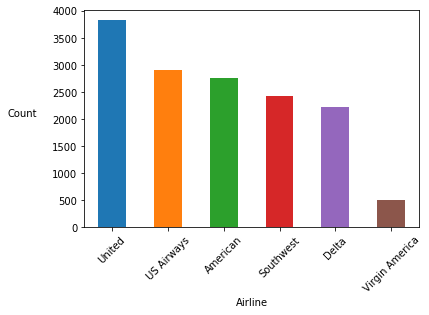

In [996]:
df.airline.value_counts().plot(kind = "bar")
plt.xlabel('Airline')
plt.xticks(rotation=45)
plt.ylabel('Count',rotation=0, labelpad=30)
# plt.title('Tweets per Airline')

## Let's look at the distribution of sentiment classes

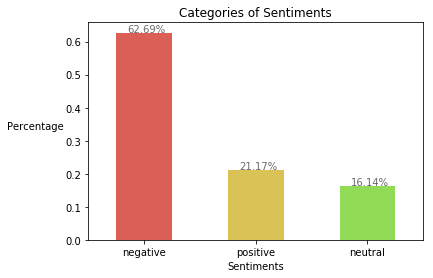

In [1019]:
color=sns.color_palette("hls", 8)

ax = (df.airline_sentiment.value_counts()/df.airline_sentiment.count()).plot(kind = "bar", color=color)
ax.set_xlabel('Sentiments')
ax.tick_params(axis = 'x', rotation=0)
ax.set_ylabel('Percentage',rotation=0, labelpad=30)
ax.set_title('Categories of Sentiments')


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar labels using above list
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.1, i.get_height()+.003, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10,
                color='dimgrey')

### We see almost 62.7% of the sentiments are negative, 21.2% are neutral and 16.1% are positive.  

### This tells us that people are almost four times more likely to tweet when they're upset than when they have positive things to say.

##  Now, let's look at sentiment counts for each airline

In [523]:
air_sentiment=pd.crosstab(df.airline, df.airline_sentiment)
air_sentiment

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


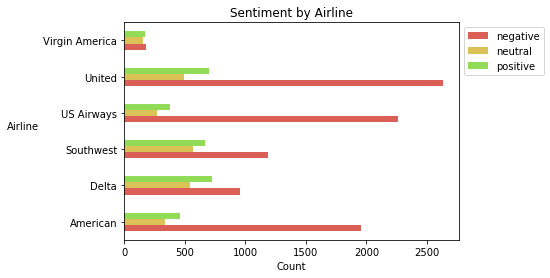

In [845]:
color=sns.color_palette("hls", 8)

airline_sentiment=pd.crosstab(df.airline, df.airline_sentiment).plot(kind='barh', color=color)
airline_sentiment

plt.xlabel('Count')
plt.ylabel('Airline', rotation=0, labelpad=20)
plt.title('Sentiment by Airline')
plt.legend(labels=['negative', 'neutral', 'positive'])
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

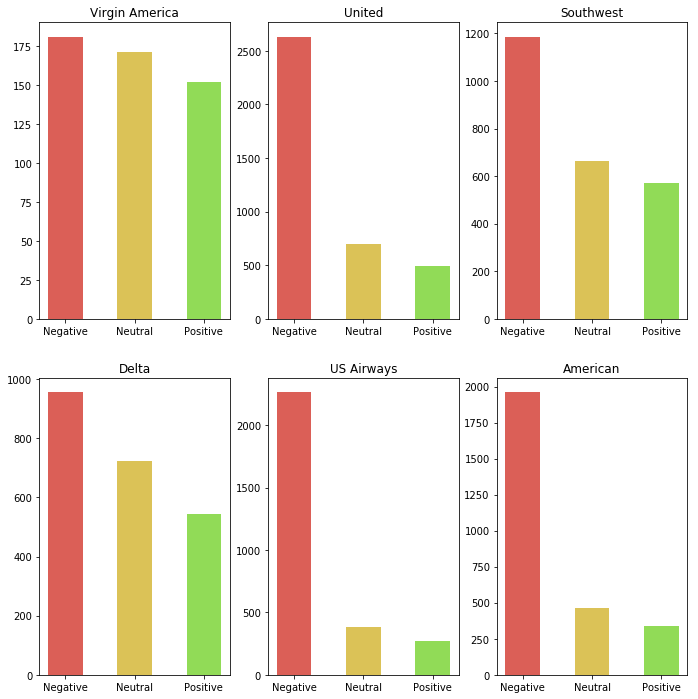

In [832]:
def plot_sub_sentiment(Airline):
    pdf = df[df['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color=sns.color_palette("hls", 8)
    plt.bar(Index,count,width=0.5,color=color)
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.title(Airline)
airline_name = df['airline'].unique()
plt.figure(1,figsize=(9,12))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.subplots_adjust(left=2, right = 3) 
    plot_sub_sentiment(airline_name[i])

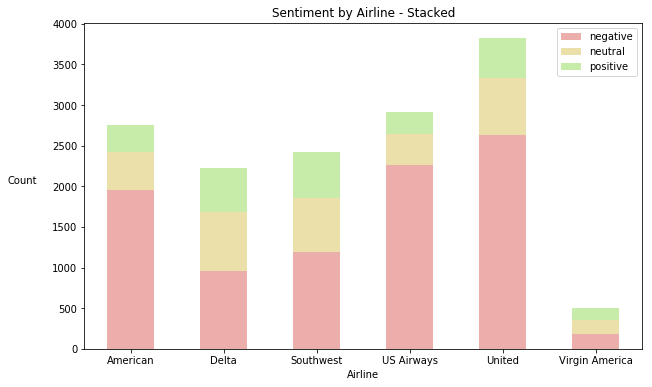

In [544]:
color=sns.color_palette("hls", 8)
pd.crosstab(index = df.airline, columns = df.airline_sentiment).plot(kind='bar',
                figsize=(10, 6),alpha=0.5,rot=0,stacked=True, color=color)
plt.xlabel('Airline')
plt.ylabel('Count',rotation=0, labelpad=30)
plt.title('Sentiment by Airline - Stacked')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.legend(labels=['negative', 'neutral', 'positive'])

In [525]:
sent_percent=air_sentiment.apply(lambda a: a / a.sum() * 100, axis=1)
sent_percent

airline_sentiment,negative,neutral,positive
airline,,,
American,71.040232,16.781443,12.178325
Delta,42.979298,32.538254,24.482448
Southwest,49.008264,27.438017,23.553719
US Airways,77.686234,13.079300,9.234466
United,68.890633,18.236525,12.872841
Virgin America,35.912698,33.928571,30.158730


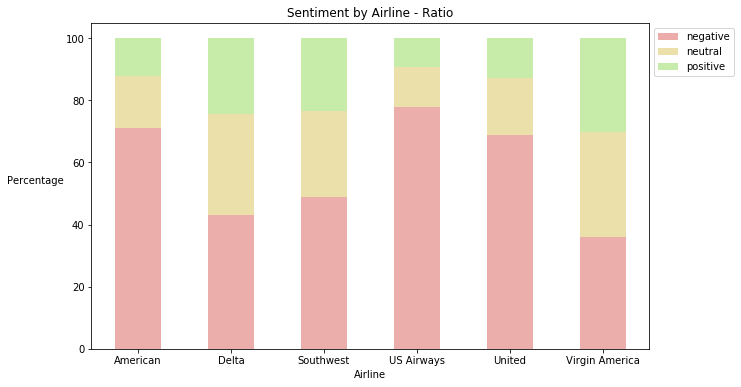

In [545]:
color=sns.color_palette("hls", 8)
sent_percent.plot(kind='bar', figsize=(10, 6), alpha=0.5, rot=0, stacked=True, color=color)
plt.xlabel('Airline')
plt.ylabel('Percentage', rotation=0, labelpad=30)
plt.title('Sentiment by Airline - Ratio')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

### We see that American and USAirways have the largest ratio of negative tweets to positive tweets, and Southwest and Virgin America are relatively balanced between the 3 sentiment classes.

In [5]:
df.negativereason.describe()

count                       9178
unique                        10
top       Customer Service Issue
freq                        2910
Name: negativereason, dtype: object

### The negative tweets were attributed to 10 different reasons.

In [6]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [906]:
df.negativereason.replace('longlines','Long Lines', inplace = True)

Text(0.5,1,'Categories of Negative Reasons')

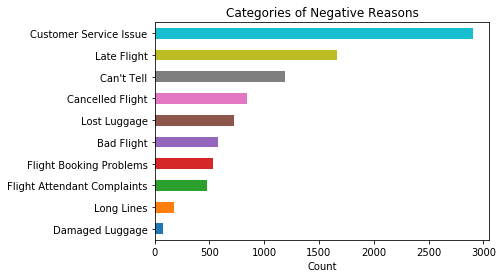

In [884]:
# Count of category occurence in data
negreas = df.negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
# plt.ylabel('Negative Reasons', rotation=0, labelpad=30)
plt.title('Categories of Negative Reasons')

### The majority of negative tweets fall into the category of 'Customer Service Issue', almost twice as many as the 2nd reason, late flight.  This could be due to people using customer service as a catch all when dealing with airline employees.

### Cancelled flight and lost luggage follow up late flight in frequency.  Then, bad flight, flight booking problems and flight attendant complaints are roughly equal. 

## Now, Let's look at negative reason by airline.

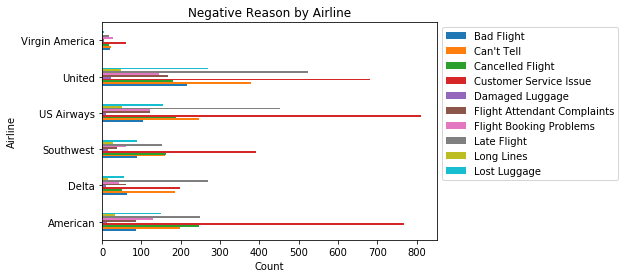

In [885]:
air_neg_sentiment=pd.crosstab(df.airline, df.negativereason).plot(kind='barh')
air_neg_sentiment
plt.xlabel('Count')
plt.ylabel('Airline')
plt.title('Negative Reason by Airline')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

Text(0.5,1,'Categories of Negative Reasons: United Airlines')

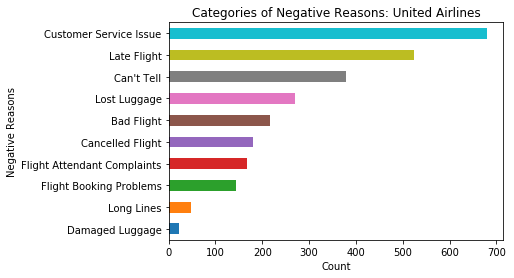

In [886]:
# Count of category occurence for United.

negreas = df[df.airline=='United'].negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.title('Categories of Negative Reasons: United Airlines')

Text(0.5,1,'Categories of Negative Reasons: US Airways')

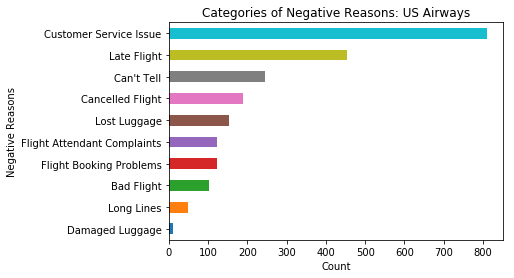

In [887]:
# Count of category occurence for US Airways.

negreas = df[df.airline=='US Airways'].negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.title('Categories of Negative Reasons: US Airways')

Text(0.5,1,'Categories of Negative Reasons: American')

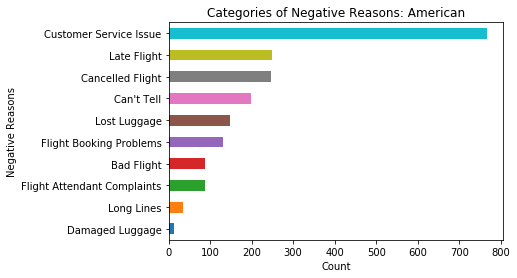

In [888]:
# Count of category occurence for American.

negreas = df[df.airline=='American'].negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.title('Categories of Negative Reasons: American')

Text(0.5,1,'Categories of Negative Reasons: Virgin America')

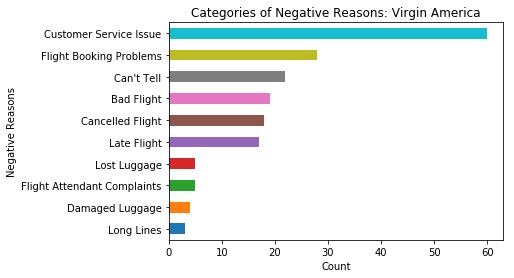

In [889]:
# Count of category occurence for Virgin.

negreas = df[df.airline=='Virgin America'].negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.title('Categories of Negative Reasons: Virgin America')

Text(0.5,1,'Categories of Negative Reasons: Delta')

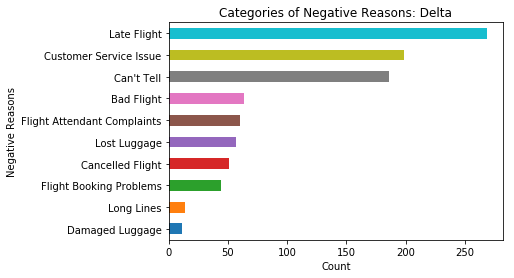

In [890]:
# Count of category occurence for Virgin.

negreas = df[df.airline=='Delta'].negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.title('Categories of Negative Reasons: Delta')

Text(0.5,1,'Categories of Negative Reasons: Southwest')

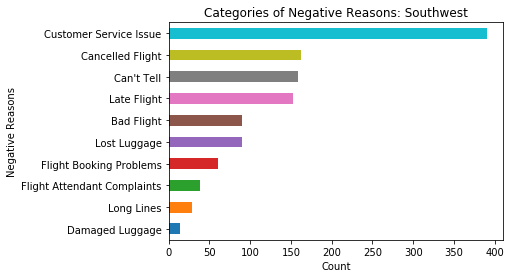

In [891]:
# Count of category occurence for Virgin.

negreas = df[df.airline=='Southwest'].negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.title('Categories of Negative Reasons: Southwest')

## Let's look at the geographic distribution of tweets.

In [892]:
df.user_timezone.value_counts()

Eastern Time (US & Canada)     3744
Central Time (US & Canada)     1931
Pacific Time (US & Canada)     1208
Quito                          738 
Atlantic Time (Canada)         497 
Mountain Time (US & Canada)    369 
Arizona                        229 
London                         195 
Alaska                         108 
Sydney                         107 
Hawaii                         104 
Amsterdam                      74  
America/Chicago                37  
Indiana (East)                 26  
America/New_York               26  
Paris                          25  
Brasilia                       23  
Abu Dhabi                      23  
Tehran                         17  
Dublin                         17  
Greenland                      17  
Santiago                       17  
Athens                         16  
New Delhi                      15  
America/Los_Angeles            15  
Casablanca                     15  
Mid-Atlantic                   15  
Buenos Aires                

In [893]:
df.tweet_location.value_counts()

Boston, MA                       157
New York, NY                     156
Washington, DC                   150
New York                         127
USA                              126
Chicago                          104
New York City                    96 
Los Angeles, CA                  96 
NYC                              95 
San Francisco, CA                91 
San Francisco                    86 
Chicago, IL                      81 
Brooklyn, NY                     66 
Los Angeles                      64 
Austin, TX                       64 
Washington, D.C.                 63 
Boston                           62 
Dallas, TX                       54 
Washington DC                    53 
Nashville, TN                    45 
NY                               42 
Texas                            42 
San Diego                        38 
Philadelphia, PA                 38 
Denver, CO                       37 
Houston, TX                      35 
Seattle                          34 
G

# Preprocessing

In [1024]:
df.airline_sentiment.replace('negative', -1, inplace = True)
df.airline_sentiment.replace('positive', 1, inplace = True)
df.airline_sentiment.replace('neutral', 0, inplace = True)

In [1018]:
# Use to revert back if necessary

df.airline_sentiment.replace(-1, 'negative', inplace = True)
df.airline_sentiment.replace(0, 'positive', inplace = True)
df.airline_sentiment.replace(1, 'neutral', inplace = True)

In [8]:
UNICODE_EMOJI

print(emoji.demojize('Python is 👍'))

Python is :thumbs_up:


# Data cleaning

## Defining functions

## Function for data cleaning using multiple regular expressions and Lemmatization

In [974]:
# Data cleaning using multiple regular expressions and Lemmatization.

stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(string):
    string = string.lower()
    string = re.sub(r"\@[a-z]+", "", string)  # remove the @airline
    string = re.sub(r"http\S+", "", string) 
    string = re.sub(r"&amp", "&", string)
    string = re.sub(r"[^a-z0-9\s]", "", string)  # remove most punctuation
    tokens = nltk.word_tokenize(string)
    
    lower_case = [l.lower() for l in tokens]    
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [985]:
print("Lemmatizing...")
lemmas_test = normalizer('This is a test of the normalizer to see neveragain what it does with a set of words and http://test.com and &amp and & and Capital PALABRAS')
print(lemmas_test)

Lemmatizing...
['test', 'normalizer', 'see', 'neveragain', 'set', 'word', 'capital', 'palabras']


## Function for data cleaning using multiple regular expressions and Stemming.

In [627]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer 

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
# stemmer = PorterStemmer()

def normalizer_by_stemming(string):
    string = string.lower()
    string = re.sub(r"\@[a-z]+", "", string)  # remove the @airline
    string = re.sub(r"http\S+", "", string)  
    string = re.sub(r"&amp", "&", string)
    string = re.sub(r"[^a-z0-9\s]", "", string)  # remove most punctuation
    tokens = nltk.word_tokenize(string)
    
    lower_case = [l.lower() for l in tokens]    
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    stems = [stemmer.stem(s) for s in filtered_result]
    return stems

In [986]:
print("Stemming...")
stemming_test = normalizer_by_stemming('This is a test of the normalizer to see neveragain what it does with a set of words and http://test.com and &amp and & and Capital PALABRAS')
print(stemming_test)

Stemming...
['test', 'normal', 'see', 'neveragain', 'set', 'word', 'capit', 'palabra']


## Function to count words

In [910]:
import collections
def count_words(input):
    total_count = collections.Counter()
    for row in input:
        for word in row:
            total_count[word] += 1
    return total_count

## Function to make word clouds

In [933]:
def mywordcloud(data, title = None):
    wordcloud = WordCloud(
        stopwords=stop_words,
        background_color='white',
        max_words=80,
        max_font_size=40,
        scale=3,
        random_state=1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8,8))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    
    plt.imshow(wordcloud)
    plt.show()

# Feature Engineering

In [912]:
tweet_created = []
for x in df.tweet_created:
    tweet_created.append(x[:19])

In [913]:
df['tweet_created'] = pd.to_datetime(df.tweet_created)
df['tweet_created_date'] = df.tweet_created.dt.date
df['tweet_created_time'] = df.tweet_created.dt.time
df['tweet_created_hour'] = df.tweet_created.dt.hour

## Let's take a look at sentiment by day

In [838]:
date_sen=pd.crosstab(df.tweet_created_date, df.airline_sentiment)
date_sen

airline_sentiment,negative,neutral,positive
tweet_created_date,,,
2015-02-17,552,181,220
2015-02-18,827,285,304
2015-02-19,666,286,346
2015-02-20,849,280,383
2015-02-21,901,245,272
2015-02-22,1744,281,367
2015-02-23,2346,458,711
2015-02-24,1293,347,496


In [839]:
percent_day=date_sen.apply(lambda a: a / a.sum() * 100, axis=1)
percent_day

airline_sentiment,negative,neutral,positive
tweet_created_date,,,
2015-02-17,57.922350,18.992655,23.084995
2015-02-18,58.403955,20.127119,21.468927
2015-02-19,51.309707,22.033898,26.656394
2015-02-20,56.150794,18.518519,25.330688
2015-02-21,63.540197,17.277856,19.181946
2015-02-22,72.909699,11.747492,15.342809
2015-02-23,66.742532,13.029872,20.227596
2015-02-24,60.533708,16.245318,23.220974


Text(0.5,0,'Count')

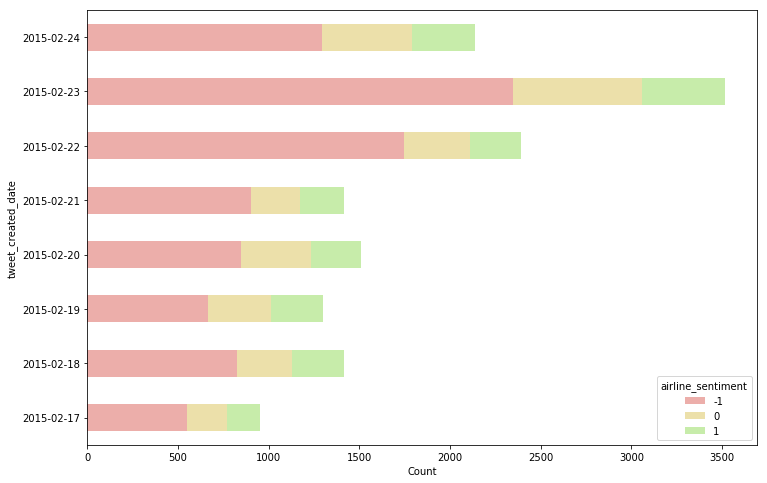

In [1001]:
color=sns.color_palette("hls", 8)

# (plots title) pd.crosstab(index = df["tweet_created_date"],columns = df["airline_sentiment"]).plot(kind='barh', color=color, figsize=(12, 8),alpha=0.5,rot=0,stacked=True,title="Airline_Sentiment_by_Date")

pd.crosstab(index = df["tweet_created_date"],columns = df["airline_sentiment"]).plot(kind='barh', color=color, figsize=(12, 8),alpha=0.5,rot=0,stacked=True)
plt.xlabel('Count')

Text(0.5,0,'Percentage')

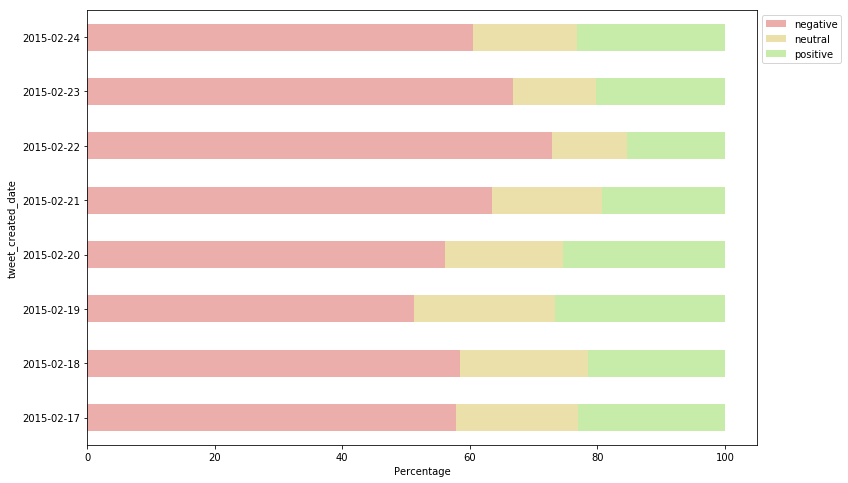

In [1000]:
color=sns.color_palette("hls", 8)

# (plts title) percent_day.plot(kind='barh',color=color, figsize=(12, 8),alpha=0.5,rot=0,stacked=True,title="Airline_Sentiment_by_Date_Percentage")

percent_day.plot(kind='barh',color=color, figsize=(12, 8),alpha=0.5,rot=0,stacked=True)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('Percentage')

In [842]:
by_hour = df.groupby(['tweet_created_hour']).negativereason.value_counts()
by_hour.unstack()

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
tweet_created_hour,,,,,,,,,,
0,35.0,57.0,37.0,131.0,1.0,22.0,18.0,111.0,38.0,13.0
1,34.0,60.0,31.0,108.0,5.0,22.0,23.0,112.0,42.0,14.0
2,28.0,54.0,43.0,156.0,5.0,20.0,26.0,99.0,40.0,6.0
3,34.0,64.0,36.0,124.0,6.0,26.0,22.0,116.0,45.0,9.0
4,20.0,52.0,35.0,115.0,4.0,24.0,22.0,70.0,40.0,7.0
5,16.0,32.0,28.0,96.0,1.0,15.0,22.0,51.0,28.0,2.0
6,13.0,21.0,17.0,72.0,2.0,14.0,12.0,32.0,27.0,5.0
7,5.0,24.0,18.0,40.0,1.0,5.0,7.0,22.0,15.0,5.0
8,10.0,14.0,11.0,27.0,NaN,4.0,2.0,13.0,15.0,1.0


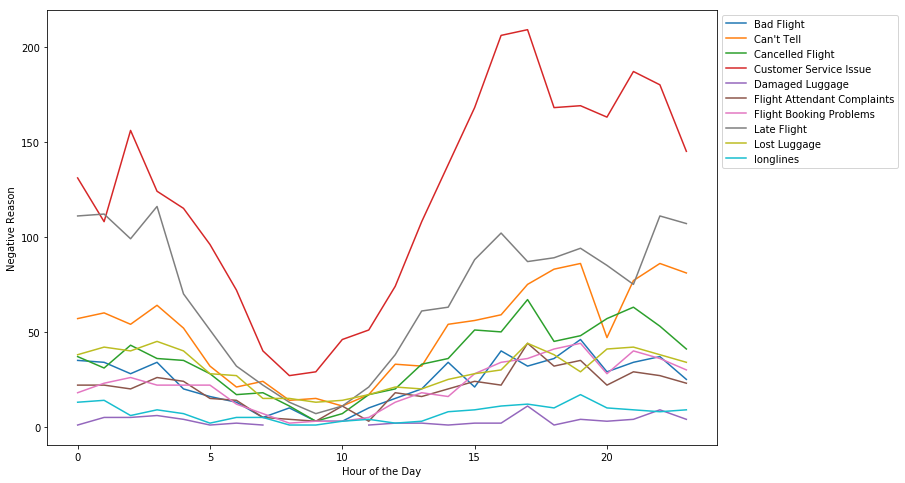

In [1003]:
# (plots title) bh_plot = by_hour.unstack().plot(kind='line',figsize=(12, 8),rot=0,title="Negetive Reasons by Time")

bh_plot = by_hour.unstack().plot(kind='line',figsize=(12, 8),rot=0)

bh_plot.set_xlabel("Hour of the Day")
bh_plot.set_ylabel("Negative Reason")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

# Analysis

## Let's start looking at the content of the first few tweets.

In [44]:
print(df.text[0])

@VirginAmerica What @dhepburn said.


In [45]:
print(df.text[1])

@VirginAmerica plus you've added commercials to the experience... tacky.


In [46]:
print(df.text[2])

@VirginAmerica I didn't today... Must mean I need to take another trip!


In [47]:
print(df.text[3])

@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse


In [48]:
print(df.text[5])

@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA


In [4]:
print(df.text[6])

@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)


## Analyze Lemmas

## View content of cells.

In [1006]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df['normalized_tweet'] = df.text.apply(normalizer)
df[['text','normalized_tweet']][16:30]

,text,normalized_tweet
16,@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo,"[excited, first, cross, country, flight, lax, mco, ive, heard, nothing, great, thing, virgin, america, 29daystogo]"
17,@VirginAmerica I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!,"[flew, nyc, sfo, last, week, couldnt, fully, sit, seat, due, two, large, gentleman, either, side, help]"
18,I ❤️ flying @VirginAmerica. ☺️👍,[flying]
19,@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.,"[know, would, amazingly, awesome, bosfll, please, want, fly]"
20,@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???,"[first, fare, may, three, time, carrier, seat, available, select]"
21,@VirginAmerica I love this graphic. http://t.co/UT5GrRwAaA,"[love, graphic]"
22,@VirginAmerica I love the hipster innovation. You are a feel good brand.,"[love, hipster, innovation, feel, good, brand]"
23,@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?,"[making, bosgtlas, non, stop, permanently, anytime, soon]"
24,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,"[guy, messed, seating, reserved, seating, friend, guy, gave, seat, away, want, free, internet]"
25,@VirginAmerica status match program. I applied and it's been three weeks. Called and emailed with no response.,"[status, match, program, applied, three, week, called, emailed, response]"


## Find the most common individual words for NEGATIVE tweets.

In [977]:
single_words_neg = df[(df.airline_sentiment == -1)][['normalized_tweet']].apply(count_words)['normalized_tweet'].most_common(50)
single_words_neg

[('flight', 3321),
 ('hour', 1079),
 ('get', 1009),
 ('cancelled', 920),
 ('customer', 773),
 ('service', 763),
 ('time', 731),
 ('u', 729),
 ('bag', 653),
 ('help', 613),
 ('hold', 609),
 ('plane', 588),
 ('2', 557),
 ('im', 547),
 ('call', 495),
 ('delayed', 493),
 ('cant', 485),
 ('still', 479),
 ('one', 444),
 ('flightled', 442),
 ('day', 438),
 ('need', 431),
 ('gate', 426),
 ('dont', 412),
 ('airline', 390),
 ('phone', 389),
 ('delay', 385),
 ('late', 377),
 ('back', 374),
 ('would', 366),
 ('seat', 358),
 ('agent', 352),
 ('waiting', 337),
 ('please', 323),
 ('minute', 310),
 ('thanks', 309),
 ('got', 307),
 ('like', 291),
 ('ive', 290),
 ('trying', 288),
 ('min', 287),
 ('3', 285),
 ('hr', 283),
 ('never', 279),
 ('wait', 271),
 ('today', 263),
 ('airport', 263),
 ('going', 252),
 ('guy', 251),
 ('make', 249)]

In [978]:
single_words_neg_df = pd.DataFrame(single_words_neg)

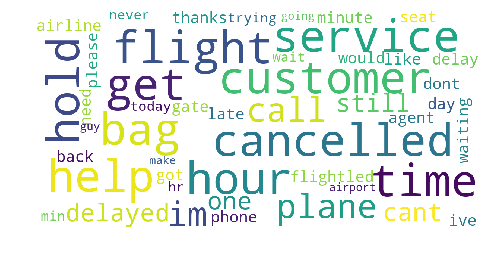

In [979]:
mywordcloud(single_words_neg_df)

In [980]:
single_words_neg_df.set_index(single_words_neg_df[0], inplace=True)

Text(0,0.5,'Single words')

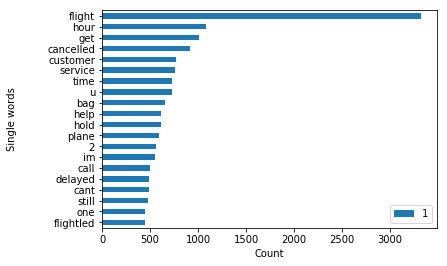

In [1005]:
# Count of negative single words

single_words_neg_df[:20].sort_values(by=[1], ascending=True).plot.barh()
plt.xlabel('Count')
plt.ylabel('Single words', rotation=90, labelpad=30)
# plt.title('Negative Reasons: Count of Single Words')

## Find the most common individual words for POSITIVE tweets.

In [982]:
single_words_pos = df[(df.airline_sentiment == 1)][['normalized_tweet']].apply(count_words)['normalized_tweet'].most_common(50)
single_words_pos

[('thanks', 609),
 ('thank', 453),
 ('flight', 433),
 ('great', 233),
 ('service', 162),
 ('u', 133),
 ('love', 133),
 ('customer', 123),
 ('guy', 123),
 ('get', 120),
 ('good', 109),
 ('much', 109),
 ('time', 106),
 ('airline', 106),
 ('best', 105),
 ('got', 101),
 ('awesome', 99),
 ('help', 84),
 ('today', 83),
 ('im', 81),
 ('crew', 80),
 ('amazing', 78),
 ('back', 72),
 ('flying', 70),
 ('gate', 65),
 ('fly', 63),
 ('made', 63),
 ('plane', 62),
 ('appreciate', 62),
 ('like', 61),
 ('make', 61),
 ('would', 60),
 ('see', 60),
 ('day', 60),
 ('well', 58),
 ('please', 58),
 ('response', 58),
 ('know', 57),
 ('home', 57),
 ('new', 55),
 ('work', 55),
 ('one', 51),
 ('agent', 50),
 ('yes', 48),
 ('go', 48),
 ('first', 48),
 ('really', 47),
 ('way', 46),
 ('thx', 46),
 ('nice', 45)]

In [969]:
single_words_pos_df = pd.DataFrame(single_words_pos)

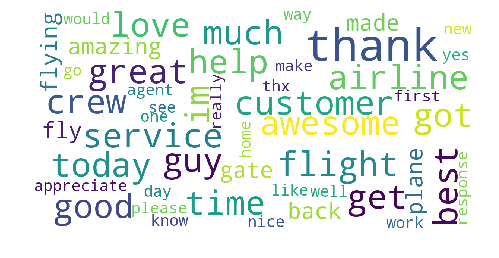

In [970]:
mywordcloud(single_words_pos_df)

## Let's summarize the top POSITIVE words in a chart.

In [971]:
single_words_pos_df.set_index(single_words_pos_df[0], inplace=True)

In [972]:
single_words_pos_df

,0,1
0,,
thanks,thanks,609
thank,thank,453
flight,flight,433
great,great,233
service,service,162
u,u,133
love,love,133
customer,customer,123
guy,guy,123


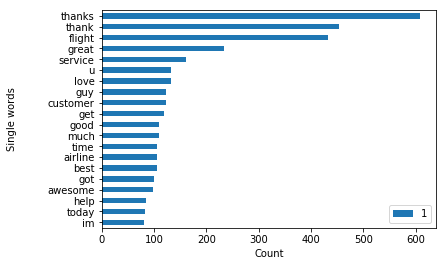

In [1004]:
# Count of single words

single_words_pos_df[:20].sort_values(by=[1], ascending=True).plot.barh()
plt.xlabel('Count')
plt.ylabel('Single words', rotation=90, labelpad=30)
# plt.title('Positive Reasons: Count of Single Words')
plt.legend()

## Let's see if bigrams and trigrams give useful results.

In [625]:
from nltk import ngrams
def ngrams(initial_list):
    bigrams = [' '.join(t) for t in list(zip(initial_list, initial_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(initial_list, initial_list[1:], initial_list[2:]))]
    return bigrams + trigrams

df['multi_grams'] = df.normalized_tweet.apply(ngrams)
df[['multi_grams']].head()

,multi_grams
0,[]
1,"[plus youve, youve added, added commercial, commercial experience, experience tacky, plus youve added, youve added commercial, added commercial experience, commercial experience tacky]"
2,"[didnt today, today must, must mean, mean need, need take, take another, another trip, didnt today must, today must mean, must mean need, mean need take, need take another, take another trip]"
3,"[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guest, guest face, face little, little recourse, really aggressive blast, aggressive blast obnoxious, blast obnoxious entertainment, obnoxious entertainment guest, entertainment guest face, guest face little, face little recourse]"
4,"[really big, big bad, bad thing, really big bad, big bad thing]"


## Find the most common BIGRAMS and TRIGRAMS for NEGATIVE tweets.

In [25]:
df[(df.airline_sentiment == 'negative')][['multi_grams']].apply(count_words)['multi_grams'].most_common(20)

[('customer service', 451),
 ('cancelled flightled', 438),
 ('late flight', 219),
 ('flight cancelled', 209),
 ('cancelled flighted', 197),
 ('2 hour', 148),
 ('late flightr', 142),
 ('cancelled flight', 136),
 ('flight cancelled flightled', 134),
 ('flightled flight', 120),
 ('cancelled flightled flight', 118),
 ('cant get', 106),
 ('flight delayed', 103),
 ('call back', 99),
 ('booking problem', 98),
 ('gate agent', 88),
 ('3 hour', 77),
 ('hour late', 73),
 ('flight flight', 72),
 ('delayed flight', 68)]

## Find the most common BIGRAMS and TRIGRAMS for POSITIVE tweets.

In [26]:
df[(df.airline_sentiment == 'positive')][['multi_grams']].apply(count_words)['multi_grams'].most_common(20)

[('customer service', 93),
 ('thank much', 36),
 ('great flight', 29),
 ('thanks much', 29),
 ('flight attendant', 28),
 ('great job', 22),
 ('thanks help', 21),
 ('cant wait', 20),
 ('best airline', 18),
 ('quick response', 18),
 ('looking forward', 18),
 ('gate agent', 17),
 ('great service', 16),
 ('booking problem', 15),
 ('good work', 15),
 ('great customer', 14),
 ('great customer service', 14),
 ('fleet fleek', 14),
 ('guy rock', 13),
 ('thanks reply', 13)]

# Stemming

## View content of cells.

In [988]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df['normalized_tweet_stem'] = df.text.apply(normalizer_by_stemming)
df[['text','normalized_tweet_stem']].head()

,text,normalized_tweet_stem
0,@VirginAmerica What @dhepburn said.,[said]
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[plus, youv, ad, commerci, experi, tacki]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[didnt, today, must, mean, need, take, anoth, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[realli, aggress, blast, obnoxi, entertain, guest, face, littl, recours]"
4,@VirginAmerica and it's a really big bad thing about it,"[realli, big, bad, thing]"


## Find the most common individual words for NEGATIVE tweets.

In [989]:
single_words_neg_stem = df[(df.airline_sentiment == -1)][['normalized_tweet_stem']].apply(count_words)['normalized_tweet_stem'].most_common(50)
single_words_neg_stem

[('flight', 3564),
 ('get', 1191),
 ('hour', 1079),
 ('cancel', 920),
 ('delay', 891),
 ('custom', 775),
 ('servic', 768),
 ('time', 743),
 ('help', 720),
 ('call', 683),
 ('wait', 663),
 ('bag', 653),
 ('hold', 647),
 ('plane', 588),
 ('2', 557),
 ('im', 547),
 ('cant', 485),
 ('us', 483),
 ('tri', 482),
 ('still', 481),
 ('need', 476),
 ('flightl', 459),
 ('go', 450),
 ('one', 444),
 ('day', 438),
 ('gate', 426),
 ('dont', 412),
 ('fli', 406),
 ('thank', 393),
 ('airlin', 392),
 ('phone', 389),
 ('seat', 378),
 ('late', 377),
 ('back', 376),
 ('would', 366),
 ('miss', 355),
 ('agent', 352),
 ('book', 336),
 ('pleas', 326),
 ('make', 321),
 ('chang', 319),
 ('minut', 310),
 ('got', 307),
 ('like', 303),
 ('check', 303),
 ('ive', 290),
 ('min', 287),
 ('3', 285),
 ('never', 279),
 ('work', 277)]

In [1007]:
single_words_neg_stem_df = pd.DataFrame(single_words_neg_stem)

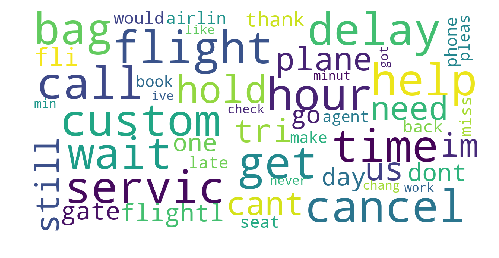

In [1008]:
mywordcloud(single_words_neg_stem_df)

In [1009]:
single_words_neg_stem_df.set_index(single_words_neg_stem_df[0], inplace=True)

Text(0,0.5,'Single words')

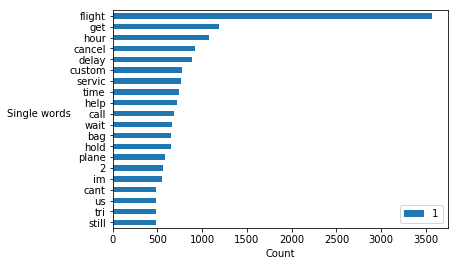

In [1015]:
# Count of negative single words

single_words_neg_stem_df[:20].sort_values(by=[1], ascending=True).plot.barh()
plt.xlabel('Count')
plt.ylabel('Single words', rotation=0, labelpad=30)
# plt.title('Negative Reasons: Count of Single Words')

## Find the most common individual words for POSITIVE tweets.

In [991]:
single_words_pos_stem = df[(df.airline_sentiment == 1)][['normalized_tweet_stem']].apply(count_words)['normalized_tweet_stem'].most_common(50)
single_words_pos_stem

[('thank', 1072),
 ('flight', 442),
 ('great', 234),
 ('servic', 162),
 ('love', 161),
 ('get', 152),
 ('help', 152),
 ('fli', 133),
 ('custom', 123),
 ('guy', 123),
 ('time', 111),
 ('good', 111),
 ('much', 109),
 ('airlin', 106),
 ('best', 105),
 ('awesom', 101),
 ('got', 101),
 ('make', 90),
 ('us', 88),
 ('work', 86),
 ('appreci', 85),
 ('amaz', 83),
 ('today', 83),
 ('im', 81),
 ('crew', 80),
 ('back', 72),
 ('gate', 65),
 ('see', 64),
 ('like', 63),
 ('made', 63),
 ('plane', 62),
 ('look', 62),
 ('pleas', 61),
 ('know', 60),
 ('would', 60),
 ('respons', 60),
 ('day', 60),
 ('go', 58),
 ('well', 58),
 ('home', 57),
 ('hope', 56),
 ('new', 55),
 ('follow', 52),
 ('one', 51),
 ('wait', 50),
 ('nice', 50),
 ('agent', 50),
 ('yes', 48),
 ('travel', 48),
 ('first', 48)]

In [1011]:
single_words_pos_stem_df = pd.DataFrame(single_words_pos_stem)

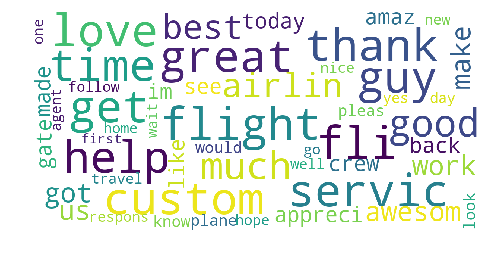

In [1012]:
mywordcloud(single_words_pos_stem_df)

## Let's summarize the top POSITIVE words in a chart.

In [994]:
print(single_words_pos_stem[1])

0
thank      1072
flight     442 
great      234 
servic     162 
love       161 
get        152 
help       152 
fli        133 
custom     123 
guy        123 
time       111 
good       111 
much       109 
airlin     106 
best       105 
awesom     101 
got        101 
make       90  
us         88  
work       86  
appreci    85  
amaz       83  
today      83  
im         81  
crew       80  
back       72  
gate       65  
see        64  
like       63  
made       63  
plane      62  
look       62  
pleas      61  
know       60  
would      60  
respons    60  
day        60  
go         58  
well       58  
home       57  
hope       56  
new        55  
follow     52  
one        51  
wait       50  
nice       50  
agent      50  
yes        48  
travel     48  
first      48  
Name: 1, dtype: int64


In [1013]:
single_words_pos_stem_df.set_index(single_words_pos_stem_df[0], inplace=True)

Text(0,0.5,'Single words')

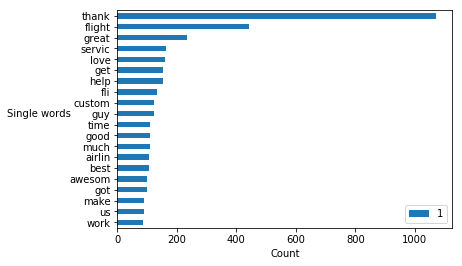

In [1016]:
# Count of negative single words

single_words_pos_stem_df[:20].sort_values(by=[1], ascending=True).plot.barh()
plt.xlabel('Count')
plt.ylabel('Single words', rotation=0, labelpad=30)
# plt.title('Negative Reasons: Count of Single Words')

## Let's see if bigrams and trigrams give useful results.

In [633]:
from nltk import ngrams
def ngrams(initial_list):
    bigrams = [' '.join(t) for t in list(zip(initial_list, initial_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(initial_list, initial_list[1:], initial_list[2:]))]
    return bigrams + trigrams

df['multi_grams_stem'] = df.normalized_tweet_stem.apply(ngrams)
df[['multi_grams_stem']].head()

,multi_grams_stem
0,[]
1,"[plus youv, youv ad, ad commerci, commerci experi, experi tacki, plus youv ad, youv ad commerci, ad commerci experi, commerci experi tacki]"
2,"[didnt today, today must, must mean, mean need, need take, take anoth, anoth trip, didnt today must, today must mean, must mean need, mean need take, need take anoth, take anoth trip]"
3,"[realli aggress, aggress blast, blast obnoxi, obnoxi entertain, entertain guest, guest face, face littl, littl recours, realli aggress blast, aggress blast obnoxi, blast obnoxi entertain, obnoxi entertain guest, entertain guest face, guest face littl, face littl recours]"
4,"[realli big, big bad, bad thing, realli big bad, big bad thing]"


## Find the most common BIGRAMS and TRIGRAMS for NEGATIVE tweets.

In [55]:
df[(df.airline_sentiment == 'negative')][['multi_grams_stem']].apply(count_words)['multi_grams_stem'].most_common(20)

[('cancel flightl', 455),
 ('custom servic', 451),
 ('cancel flight', 369),
 ('late flight', 226),
 ('flight cancel', 209),
 ('flight flight', 149),
 ('2 hour', 148),
 ('late flightr', 143),
 ('cancel flight flight', 137),
 ('flight cancel flightl', 134),
 ('flightl flight', 128),
 ('cancel flightl flight', 126),
 ('flight delay', 119),
 ('call back', 110),
 ('cant get', 106),
 ('miss connect', 102),
 ('book problem', 97),
 ('delay flight', 93),
 ('gate agent', 88),
 ('3 hour', 77)]

## Find the most common BIGRAMS and TRIGRAMS for POSITIVE tweets.

In [56]:
df[(df.airline_sentiment == 'positive')][['multi_grams_stem']].apply(count_words)['multi_grams_stem'].most_common(20)

[('custom servic', 93),
 ('thank much', 65),
 ('thank help', 37),
 ('great flight', 29),
 ('flight attend', 29),
 ('look forward', 25),
 ('great job', 22),
 ('thank great', 21),
 ('cant wait', 20),
 ('best airlin', 18),
 ('quick respons', 18),
 ('great thank', 18),
 ('gate agent', 17),
 ('ok thank', 17),
 ('awesom thank', 17),
 ('thank quick', 16),
 ('great servic', 16),
 ('thank repli', 16),
 ('thank guy', 15),
 ('fli guy', 15)]

# Modeling normalized (lemmatized) tweets

## Normalize and lemmatize tweets

In [378]:
tweets = []
for tweet in df['text']:
    w = normalizer(tweet)
    tweets.append(w)

In [152]:
print(df.text[:6])

0    @VirginAmerica What @dhepburn said.                                                                                                     
1    @VirginAmerica plus you've added commercials to the experience... tacky.                                                                
2    @VirginAmerica I didn't today... Must mean I need to take another trip!                                                                 
3    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse          
4    @VirginAmerica and it's a really big bad thing about it                                                                                 
5    @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
Name: text, dtype: object


In [37]:
print(tweets[0:4])

[['said'], ['plus', 'youve', 'added', 'commercial', 'experience', 'tacky'], ['didnt', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip'], ['really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guest', 'face', 'little', 'recourse']]


## Join lemmas together to vectorize 

In [379]:
s = ' ' 

joined_tweets = []
for t in tweets:
    joined_tweets.append(s.join(t)) 

print(joined_tweets[:4]) 

['said', 'plus youve added commercial experience tacky', 'didnt today must mean need take another trip', 'really aggressive blast obnoxious entertainment guest face little recourse']


## Vectorize joined tweets

In [380]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Creating Vectorizer and transforming data
cv = TfidfVectorizer(ngram_range=(1,1), stop_words='english', strip_accents='unicode')

#Applying the vectorizer
tweets_tfidf = cv.fit_transform(joined_tweets)
print("Number of features: %d" % tweets_tfidf.get_shape()[1])

Number of features: 13497


## Set features and target variable

In [1026]:
Y = df.airline_sentiment
features = tweets_tfidf

## Split TFIDF data into training and test sets.

In [1027]:
# splitting features into training and test sets
X_train, X_test = train_test_split(tweets, test_size=0.2, random_state=0)

In [1028]:
# splitting tfidf matrix into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=0)

In [719]:
# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of tweets
n = X_train_tfidf_csr.shape[0]

# A list of dictionaries, one per tweet
tfidf_bytweet = [{} for _ in range(0,n)]

# List of features
terms = cv.get_feature_names()

# For each tweet, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bytweet[i][terms[j]] = X_train_tfidf_csr[i, j]

print('Original tweet:', X_train[5])
print('Tf_idf vector:', tfidf_bytweet[5])

Original tweet: ['222mdw', '2', 'san', 'flt', '1687', 'attendant', 'melissa', 'awesome', 'fast', 'smiling', 'great', 'weather', 'cancelled', 'flight', 'day', 'b4', 'welcome']
Tf_idf vector: {'melissa': 0.358038369995988, '1687': 0.3433722048522937, '222mdw': 0.358038369995988, 'smiling': 0.3183002299383234, 'fast': 0.27856208988065884, 'b4': 0.28282244525407685, 'attendant': 0.2035982303669951, 'day': 0.15690176543709528, 'welcome': 0.27660641285653625, 'flt': 0.2051486625874152, 'san': 0.22646246302859552, 'weather': 0.17752836557744447, 'cancelled': 0.13281698043889528, 'awesome': 0.20964077939181794, 'great': 0.17491816230055193, 'flight': 0.08459992667510349}


## Define function to score models

In [702]:
# Calculate accuracy and perform cross validation.
# Get accuracy score on test set.  Cross validate on training set.

def get_scores(classifier, x, y):
    
    # Cross validation.
    cv_train = cross_val_score(classifier, X_train_tfidf, y_train, cv=5)
    plusminus = u"\u00B1"
    print('Cross validation results: {:.3%} {} {:.3%} \n {}'.format(cv_train.mean(), plusminus, cv_train.std(), cv_train))
    
    # Make class predictions for the testing set.
    y_pred_class = classifier.predict(x)
    
    # Calculate accuracy.
    print ('Accuracy score:', round(metrics.accuracy_score(y, y_pred_class),3))
    print()

## Look at original distribution of classes

In [1029]:
print(y_test.value_counts().head(3) / len(y_test))

-1    0.638661
 1    0.209699
 0    0.151639
Name: airline_sentiment, dtype: float64


### We'll run models as is and then address the class imbalance and run models again.

## Naive Bayes

In [721]:
start_time = time.clock()

# Import model
from sklearn.naive_bayes import MultinomialNB

# Create instance
clf = MultinomialNB()

# Fit training data
clf.fit(X_train_tfidf, y_train)

print('Runtime for Naive Bayes: '+'%s seconds'% (time.clock() - start_time))

Runtime for Naive Bayes: 0.0062554000178352 seconds


## Check accuracy of model

In [722]:
# Get accuracy scores on training and test sets.

accuracy_train = round(clf.score(X_train_tfidf, y_train), 3)
accuracy_test = round(clf.score(X_test_tfidf, y_test), 3)

print('Naive Bayes training accuracy score: ', accuracy_train)
print('Naive Bayes test accuracy score: ', accuracy_test)

Naive Bayes training accuracy score:  0.737
Naive Bayes test accuracy score:  0.69


## Cross Validation

In [723]:
start_time = time.clock()

# Print results
get_scores(clf, X_test_tfidf, y_test)

print('Runtime for Naive Bayes 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 67.649% ± 0.451% 
 [0.66837388 0.67904396 0.67477593 0.68018787 0.68005126]
Accuracy score: 0.69

Runtime for Naive Bayes 5-fold cross validation: 0.04599010001402348 seconds


In [724]:
y_pred = clf.predict(X_test_tfidf)

In [725]:
y_pred

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [726]:
np.sum(y_pred)

-2619

In [727]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.6895491803278688


In [728]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1849   19    2]
 [ 502   98   14]
 [ 356   16   72]]


In [729]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.68      0.99      0.81      1870
     neutral       0.74      0.16      0.26       614
    positive       0.82      0.16      0.27       444

   micro avg       0.69      0.69      0.69      2928
   macro avg       0.75      0.44      0.45      2928
weighted avg       0.71      0.69      0.61      2928



## Logistic Regression

### Grid Search

In [1030]:
start_time = time.clock()

# Create a new instance for regularization
logit = LogisticRegression()

# Specify regularization penalties
penalty = ['l1', 'l2']

# Specify regularization hyperparameter range
C = np.logspace(1, 15, 2)

# Set hyperparameters 
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logit, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train_tfidf, y_train)

# Get results
print('Best Penalty:', results.best_estimator_.get_params()['penalty'])
print('Best C:', results.best_estimator_.get_params()['C'])
print('Best cross validation score:', round(results.best_score_, 3))

print('Runtime for Logistic Regression: '+'%s seconds'% (time.clock() - start_time)) 

Best Penalty: l2
Best C: 10.0
Best cross validation score: 0.775
Runtime for Logistic Regression: 65.52266180003062 seconds


In [1031]:
# Get accuracy scores on training and test sets.

print('Logistic regression training accuracy score: ', round(results.score(X_train_tfidf, y_train), 3))
print('Logistic regression test accuracy score: ', round(results.score(X_test_tfidf, y_test), 3))

Logistic regression training accuracy score:  0.947
Logistic regression test accuracy score:  0.775


In [732]:
start_time = time.clock()

# Print results.  Accuracy score on test set.  Cross validation on training set.
get_scores(results, X_test_tfidf, y_test)

print('Runtime for Logistic Regression 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 77.459% ± 0.455% 
 [0.7767819  0.76739223 0.77123346 0.77924851 0.77829987]
Accuracy score: 0.775

Runtime for Logistic Regression 5-fold cross validation: 104.85791829996742 seconds


## Confusion Matrix - Logistic Regression

In [1032]:
# Examine the class distribution of the testing set.
y_test.value_counts()

-1    1870
 1    614 
 0    444 
Name: airline_sentiment, dtype: int64

In [1035]:
y_pred = results.predict(X_test_tfidf)

In [1037]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.7752732240437158


In [1036]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1684   36  150]
 [ 119  260   65]
 [ 248   40  326]]


In [1038]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.82      0.90      0.86      1870
     neutral       0.77      0.59      0.67       444
    positive       0.60      0.53      0.56       614

   micro avg       0.78      0.78      0.78      2928
   macro avg       0.73      0.67      0.70      2928
weighted avg       0.77      0.78      0.77      2928



In [736]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

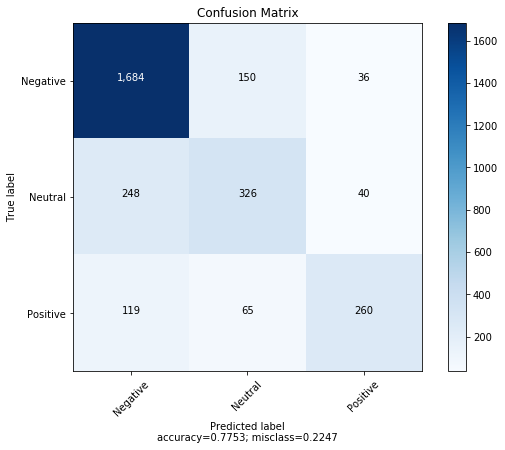

In [737]:
plot_confusion_matrix(cm           = np.array(c_matrix), 
                      normalize    = False,
                      target_names = ['Negative', 'Neutral', 'Positive'],
                      title        = "Confusion Matrix")

## Random Forest

### Grid Search

In [1041]:
start_time = time.clock()

from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [40,50,60,70,80,90,100]}
rfc = GridSearchCV(RandomForestClassifier(), param_grid)
rfc = rfc.fit(X_train_tfidf, y_train)
print("Best parameters found by grid search:")
print(rfc.best_params_)
print("Best CV score:")
print(rfc.best_score_)

print('Runtime for Random Forest: '+'%s seconds'% (time.clock() - start_time))

Best parameters found by grid search:
{'n_estimators': 90}
Best CV score:
0.7533299180327869
Runtime for Random Forest: 303.9405635999865 seconds


In [743]:
# Get accuracy scores on training and test sets.

accuracy_train = round(rfc.score(X_train_tfidf, y_train), 3)
accuracy_test = round(rfc.score(X_test_tfidf, y_test), 3)

print('Random Forest training accuracy score: ', accuracy_train)
print('Random Forest test accuracy score: ', accuracy_test)

Random Forest training accuracy score:  0.993
Random Forest test accuracy score:  0.758


In [744]:
# Print results.  Accuracy score on test set.  Cross validation on training set.

start_time = time.clock()

get_scores(rfc, X_test_tfidf, y_test)

print('Runtime for Random Forest 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 75.316% ± 0.532% 
 [0.74647887 0.75373453 0.75245412 0.76259607 0.75053396]
Accuracy score: 0.758

Runtime for Random Forest 5-fold cross validation: 1112.815299800015 seconds


In [1042]:
y_pred = rfc.predict(X_test_tfidf)

In [1043]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.7588797814207651


In [1044]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1699   35  136]
 [ 152  239   53]
 [ 283   47  284]]


In [1045]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.80      0.91      0.85      1870
     neutral       0.74      0.54      0.62       444
    positive       0.60      0.46      0.52       614

   micro avg       0.76      0.76      0.76      2928
   macro avg       0.71      0.64      0.67      2928
weighted avg       0.75      0.76      0.75      2928



## Support Vector Machines

### Grid Search

In [1048]:
start_time = time.clock()
    
# Support Vector Machine - Grid Search

# Create instance
svc = svm.SVC(kernel ='linear')

# other kernel was 'rbf'

# Specify hyperparameter range
C = [0.01, 0.1, 1, 10]

# Set hyperparameters 
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
svc_clf = GridSearchCV(svc, hyperparameters, cv=5)

# Run grid search
svc_results = svc_clf.fit(X_train_tfidf, y_train)

# Get results
print('C:', svc_results.best_estimator_.get_params()['C'])
print('Best score:', round(svc_results.best_score_, 3))
    
print('Runtime for SVM: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

C: 1
Best score: 0.773
Runtime for SVM: 266.2680596000282 seconds


In [746]:
# Get accuracy scores on training and test sets.

accuracy_train = round(svc_results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(svc_results.score(X_test_tfidf, y_test), 3)

print('Support Vector Machine training accuracy score: ', accuracy_train)
print('Support Vector Machine test accuracy score: ', accuracy_test)

Support Vector Machine training accuracy score:  0.901
Support Vector Machine test accuracy score:  0.78


In [747]:
start_time = time.clock()

# Print results

get_scores(svc_results, X_test_tfidf, y_test)

print('Runtime for SVM 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 77.271% ± 0.593% 
 [0.77934272 0.76525822 0.76739223 0.77198975 0.77958138]
Accuracy score: 0.78

Runtime for SVM 5-fold cross validation: 814.1506240000017 seconds


In [1049]:
y_pred = svc_results.predict(X_test_tfidf)

In [1050]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.7800546448087432


In [1051]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1717   36  117]
 [ 118  276   50]
 [ 282   41  291]]


In [1052]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.81      0.92      0.86      1870
     neutral       0.78      0.62      0.69       444
    positive       0.64      0.47      0.54       614

   micro avg       0.78      0.78      0.78      2928
   macro avg       0.74      0.67      0.70      2928
weighted avg       0.77      0.78      0.77      2928



## Gradient Boosting

In [1053]:
start_time = time.clock()

# Gradient Boosted Forest - Grid Search

# Create instance
gbc = ensemble.GradientBoostingClassifier(
    random_state=42
)

# Specify hyperparameter range
loss = ['deviance']
n_estimators = np.arange(100, 130, 5)
max_depth = np.arange(2, 5, 1)

# Set hyperparameters 
hyperparameters = dict(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    loss=loss 
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(gbc, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train_tfidf, y_train)

# Get results
print('n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Loss function: ', results.best_estimator_.get_params()['loss'])
print('Best score:', round(results.best_score_, 3))

print('Runtime for Gradient Boosting with: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

n estimators: 125
Max depth: 4
Loss function:  deviance
Best score: 0.723
Runtime for Gradient Boosting with: 2792.2762396000326 seconds


In [1054]:
# Get accuracy scores on training and test sets.

accuracy_train = round(results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(results.score(X_test_tfidf, y_test), 3)

print('Gradient Boosting training accuracy score: ', accuracy_train)
print('Gradient Boosting test accuracy score: ', accuracy_test)

Gradient Boosting training accuracy score:  0.762
Gradient Boosting test accuracy score:  0.732


In [750]:
start_time = time.clock()

# Print results

get_scores(results, X_test_tfidf, y_test)

print('Runtime for Gradient Boosting 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 72.353% ± 0.256% 
 [0.72513871 0.72087068 0.72684592 0.72459436 0.72020504]
Accuracy score: 0.733

Runtime for Gradient Boosting 5-fold cross validation: 10113.905962600023 seconds


In [1055]:
y_pred = results.predict(X_test_tfidf)

In [1056]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.73224043715847


In [1057]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1793   52   25]
 [ 186  243   15]
 [ 468   38  108]]


In [1058]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.73      0.96      0.83      1870
     neutral       0.73      0.55      0.63       444
    positive       0.73      0.18      0.28       614

   micro avg       0.73      0.73      0.73      2928
   macro avg       0.73      0.56      0.58      2928
weighted avg       0.73      0.73      0.68      2928



# Run Models with stems

## View content of cells.

In [232]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df[['text','normalized_tweet_stem']][16:30]

,text,normalized_tweet_stem
16,@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo,"[excit, first, cross, countri, flight, lax, mco, ive, heard, noth, great, thing, virgin, america, 29daystogo]"
17,@VirginAmerica I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!,"[flew, nyc, sfo, last, week, couldnt, fulli, sit, seat, due, two, larg, gentleman, either, side, help]"
18,I ❤️ flying @VirginAmerica. ☺️👍,[fli]
19,@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.,"[know, would, amaz, awesom, bosfll, pleas, want, fli]"
20,@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???,"[first, fare, may, three, time, carrier, seat, avail, select]"
21,@VirginAmerica I love this graphic. http://t.co/UT5GrRwAaA,"[love, graphic]"
22,@VirginAmerica I love the hipster innovation. You are a feel good brand.,"[love, hipster, innov, feel, good, brand]"
23,@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?,"[make, bosgtla, non, stop, perman, anytim, soon]"
24,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,"[guy, mess, seat, reserv, seat, friend, guy, gave, seat, away, want, free, internet]"
25,@VirginAmerica status match program. I applied and it's been three weeks. Called and emailed with no response.,"[status, match, program, appli, three, week, call, email, respons]"


## Normalize & stemmatize tweets

In [389]:
tweets_stems = []
for tweet in df['text']:
    w = normalizer_by_stemming(tweet)
    tweets_stems.append(w)

## Join stems together to vectorize 

In [390]:
s = ' ' 

joined_tweets_stems = []
for t in tweets_stems:
    joined_tweets_stems.append(s.join(t)) 

print(joined_tweets_stems[:4]) 

['said', 'plus youv ad commerci experi tacki', 'didnt today must mean need take anoth trip', 'realli aggress blast obnoxi entertain guest face littl recours']


## Vectorize joined tweets

In [391]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Creating Vectorizer and transforming data
cv2 = TfidfVectorizer(ngram_range=(1,1), stop_words='english', strip_accents='unicode')

#Applying the vectorizer
tweets_stems_tfidf = cv2.fit_transform(joined_tweets_stems)
print("Number of features: %d" % tweets_stems_tfidf.get_shape()[1])

Number of features: 11756


## Set features and target variable

In [1059]:
Y = df.airline_sentiment
features = tweets_stems_tfidf

## Split TFIDF data into training and test sets.

In [1060]:
# splitting into training and test sets
X_train, X_test = train_test_split(tweets, test_size=0.2, random_state=0)

In [1061]:
from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=0)

In [671]:
#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of tweets
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per tweet
tfidf_of_stems_bytweet = [{} for _ in range(0,n)]
#List of features
terms = cv2.get_feature_names()
#for each tweet, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_of_stems_bytweet[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original tweet:', X_train[5])
print('Tf_idf vector:', tfidf_of_stems_bytweet[5])    


Original tweet: ['222mdw', '2', 'san', 'flt', '1687', 'attendant', 'melissa', 'awesome', 'fast', 'smiling', 'great', 'weather', 'cancelled', 'flight', 'day', 'b4', 'welcome']
Tf_idf vector: {'melissa': 0.36177657257114615, '1687': 0.3469572811122235, '222mdw': 0.36177657257114615, 'smile': 0.2933643184505015, 'fast': 0.28147049749558845, 'b4': 0.2857753343345773, 'attend': 0.20277883052861573, 'day': 0.1585399434446937, 'welcom': 0.2758364643635889, 'flt': 0.2072905762007051, 'san': 0.2288269095053227, 'weather': 0.17925779659568178, 'cancel': 0.134203694321843, 'awesom': 0.2112304190229616, 'great': 0.17674444568118844, 'flight': 0.08501954828427777}


## Naive Bayes

In [1062]:
start_time = time.clock()

# Naive Bayes 

# Import model
from sklearn.naive_bayes import MultinomialNB

# Create instance
clf = MultinomialNB()

# Fit training data
clf.fit(X_train_tfidf, y_train)

print('Runtime for fitting Naive Bayes: '+'%s seconds'% (time.clock() - start_time))

Runtime for fitting Naive Bayes: 0.00633980002021417 seconds


## Check accuracy of model

In [1063]:
# Get accuracy scores on training and test sets.

accuracy_train = round(clf.score(X_train_tfidf, y_train), 3)
accuracy_test = round(clf.score(X_test_tfidf, y_test), 3)

print('Naive Bayes training accuracy score: ', accuracy_train)
print('Naive Bayes test accuracy score: ', accuracy_test)

Naive Bayes training accuracy score:  0.73
Naive Bayes test accuracy score:  0.69


## Cross Validation

In [674]:
start_time = time.clock()

# Print results

get_scores(clf, X_test_tfidf, y_test)

print('Runtime for Naive Bayes cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 67.333% ± 0.425% 
 [0.66623986 0.67520273 0.6713615  0.67506405 0.67876976]
Accuracy score: 0.69

Runtime for Naive Bayes cross validation: 0.19027420005295426 seconds


In [1064]:
y_pred = clf.predict(X_test_tfidf)

In [1065]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.6895491803278688


In [1066]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1850    0   20]
 [ 353   74   17]
 [ 505   14   95]]


In [1067]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.68      0.99      0.81      1870
     neutral       0.84      0.17      0.28       444
    positive       0.72      0.15      0.25       614

   micro avg       0.69      0.69      0.69      2928
   macro avg       0.75      0.44      0.45      2928
weighted avg       0.71      0.69      0.61      2928



## Logistic Regression

### Grid Search

In [1068]:
start_time = time.clock()

# Create a new instance for regularization
logit = LogisticRegression()

# Specify regularization penalties
penalty = ['l1', 'l2']

# Specify regularization hyperparameter range
C = np.logspace(1, 15, 2)

# Set hyperparameters 
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logit, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train_tfidf, y_train)

# Get results
print('Best Penalty:', results.best_estimator_.get_params()['penalty'])
print('Best C:', results.best_estimator_.get_params()['C'])
print('Best cross validation score:', round(results.best_score_, 3))

print('Runtime for fitting Logistic Regression: '+'%s seconds'% (time.clock() - start_time))

Best Penalty: l2
Best C: 10.0
Best cross validation score: 0.775
Runtime for fitting Logistic Regression: 53.24476880003931 seconds


In [1069]:
# Get accuracy scores on training and test sets.

print('Logistic regression training accuracy score: ', round(results.score(X_train_tfidf, y_train), 3))
print('Logistic regression test accuracy score: ', round(results.score(X_test_tfidf, y_test), 3))

Logistic regression training accuracy score:  0.938
Logistic regression test accuracy score:  0.774


In [681]:
start_time = time.clock()

# Print results.  Accuracy score on test set.  Cross validation on training set.

get_scores(results, X_test_tfidf, y_test)

print('Runtime for Logistic Regression cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 77.502% ± 0.284% 
 [0.77507469 0.77166026 0.77208707 0.77882152 0.77744554]
Accuracy score: 0.774

Runtime for Logistic Regression cross validation: 787.1092684000032 seconds


## Confusion Matrix - Logistic Regression

In [1070]:
# Examine the class distribution of the testing set.
y_test.value_counts()

-1    1870
 1    614 
 0    444 
Name: airline_sentiment, dtype: int64

In [1071]:
y_pred = results.predict(X_test_tfidf)

In [1072]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1692   33  145]
 [ 120  256   68]
 [ 252   45  317]]


In [1073]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.82      0.90      0.86      1870
     neutral       0.77      0.58      0.66       444
    positive       0.60      0.52      0.55       614

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.73      0.67      0.69      2928
weighted avg       0.77      0.77      0.77      2928



In [687]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

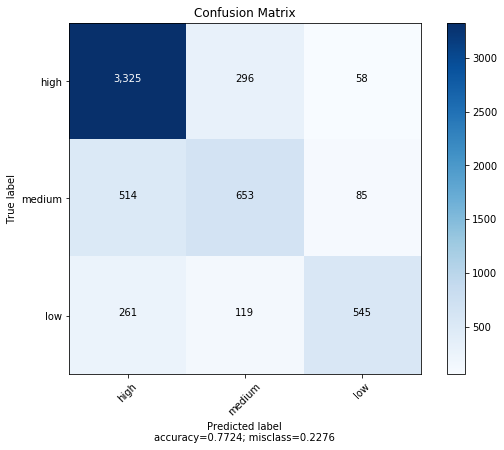

In [688]:
plot_confusion_matrix(cm           = np.array([[ 3325,  296, 58],
                                              [  514,  653,  85],
                                              [  261,  119, 545]]), 
                      normalize    = False,
                      target_names = ['high', 'medium', 'low'],
                      title        = "Confusion Matrix")

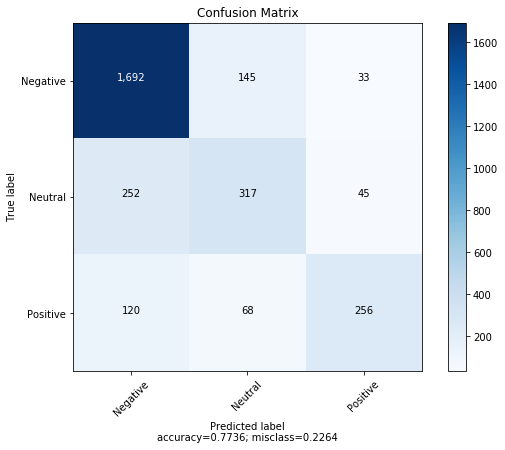

In [689]:
plot_confusion_matrix(cm           = np.array(c_matrix), 
                      normalize    = False,
                      target_names = ['Negative', 'Neutral', 'Positive'],
                      title        = "Confusion Matrix")

## Random Forest

### Grid Search

In [1074]:
start_time = time.clock()

# Random Forest - Grid Search

from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [40,50,60,70,80,90,100]}
rfc = GridSearchCV(RandomForestClassifier(), param_grid)
rfc = rfc.fit(X_train_tfidf, y_train)
print("Best parameters found by grid search:")
print(rfc.best_params_)
print("Best CV score:")
print(rfc.best_score_)

print('Runtime for fitting Random Forest: '+'%s seconds'% (time.clock() - start_time))

Best parameters found by grid search:
{'n_estimators': 100}
Best CV score:
0.7627219945355191
Runtime for fitting Random Forest: 286.3974552999716 seconds


In [1075]:
# Get accuracy scores on training and test sets.

accuracy_train = round(rfc.score(X_train_tfidf, y_train), 3)
accuracy_test = round(rfc.score(X_test_tfidf, y_test), 3)

print('Random Forest training accuracy score: ', accuracy_train)
print('Random Forest test accuracy score: ', accuracy_test)

Random Forest training accuracy score:  0.993
Random Forest test accuracy score:  0.767


In [692]:
# Print results.  Accuracy score on test set.  Cross validation on training set.

start_time = time.clock()

get_scores(rfc, X_test_tfidf, y_test)

print('Runtime for Random Forest 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 76.093% ± 0.469% 
 [0.75586854 0.76653863 0.7626974  0.75491033 0.7646305 ]
Accuracy score: 0.768

Runtime for Random Forest 5-fold cross validation: 988.4892196999863 seconds


In [1076]:
y_pred = rfc.predict(X_test_tfidf)

In [1077]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1719   34  117]
 [ 155  247   42]
 [ 290   44  280]]


In [1078]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.76      0.56      0.64       444
    positive       0.64      0.46      0.53       614

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.73      0.64      0.68      2928
weighted avg       0.76      0.77      0.75      2928



## Support Vector Machines

### Grid Search

In [1079]:
start_time = time.clock()
    
# Support Vector Machine - Grid Search

# Create instance
svc = svm.SVC(kernel ='linear')

# other kernel was 'rbf'

# Specify hyperparameter range
C = [0.01, 0.1, 1, 10]

# Set hyperparameters 
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
svc_clf = GridSearchCV(svc, hyperparameters, cv=5)

# Run grid search
svc_results = svc_clf.fit(X_train_tfidf, y_train)

# Get results
print('C:', svc_results.best_estimator_.get_params()['C'])
print('Best score:', round(svc_results.best_score_, 3))
    
print('Runtime for SVM: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

C: 1
Best score: 0.773
Runtime for SVM: 252.27940860000672 seconds


In [1080]:
# Get accuracy scores on training and test sets.

accuracy_train = round(svc_results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(svc_results.score(X_test_tfidf, y_test), 3)

print('Support Vector Machine training accuracy score: ', accuracy_train)
print('Support Vector Machine test accuracy score: ', accuracy_test)

Support Vector Machine training accuracy score:  0.891
Support Vector Machine test accuracy score:  0.77


In [695]:
start_time = time.clock()

# Print results

get_scores(svc_results, X_test_tfidf, y_test)

print('Runtime for SVM 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 77.340% ± 0.413% 
 [0.76824584 0.77720871 0.77336748 0.76942784 0.77872704]
Accuracy score: 0.77

Runtime for SVM 5-fold cross validation: 779.7440951999743 seconds


In [1081]:
y_pred = svc_results.predict(X_test_tfidf)

In [1082]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1699   44  127]
 [ 130  261   53]
 [ 277   42  295]]


In [1083]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.81      0.91      0.85      1870
     neutral       0.75      0.59      0.66       444
    positive       0.62      0.48      0.54       614

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.73      0.66      0.69      2928
weighted avg       0.76      0.77      0.76      2928



## Gradient Boosting

In [1084]:
start_time = time.clock()

# Gradient Boosted Forest - Grid Search

# Create instance
gbc = ensemble.GradientBoostingClassifier(
    random_state=42
)

# Specify hyperparameter range
loss = ['deviance']
n_estimators = np.arange(100, 130, 5)
max_depth = np.arange(2, 5, 1)

# Set hyperparameters 
hyperparameters = dict(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    loss=loss 
)

# Create grid search using 5-fold cross validation
gbc = GridSearchCV(gbc, hyperparameters, cv=5)

# Run grid search
gbc_results = gbc.fit(X_train_tfidf, y_train)

# Get results
print('n estimators:', gbc_results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', gbc_results.best_estimator_.get_params()['max_depth'])
print('Loss function: ', gbc_results.best_estimator_.get_params()['loss'])
print('Best score:', round(gbc_results.best_score_, 3))

print('Runtime for Gradient Boosting with: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

n estimators: 125
Max depth: 4
Loss function:  deviance
Best score: 0.726
Runtime for Gradient Boosting with: 2572.7713130000047 seconds


In [1085]:
# Get accuracy scores on training and test sets.

accuracy_train = round(gbc_results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(gbc_results.score(X_test_tfidf, y_test), 3)

print('Gradient Boosting training accuracy score: ', accuracy_train)
print('Gradient Boosting test accuracy score: ', accuracy_test)

Gradient Boosting training accuracy score:  0.77
Gradient Boosting test accuracy score:  0.74


In [1089]:
start_time = time.clock()

# Print results

get_scores(gbc_results, X_test_tfidf, y_test)

print('Runtime for Gradient Boosting 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 72.626% ± 0.298% 
 [0.73111396 0.7238583  0.7234315  0.72459436 0.72832123]
Accuracy score: 0.74

Runtime for Gradient Boosting 5-fold cross validation: 9274.37057150004 seconds


In [1090]:
y_pred = gbc_results.predict(X_test_tfidf)

In [1091]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1795   52   23]
 [ 168  259   17]
 [ 464   36  114]]


In [1092]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.74      0.96      0.84      1870
     neutral       0.75      0.58      0.65       444
    positive       0.74      0.19      0.30       614

   micro avg       0.74      0.74      0.74      2928
   macro avg       0.74      0.58      0.60      2928
weighted avg       0.74      0.74      0.70      2928



#  Addressing class imbalance

## SMOTE Lemmas

## Vectorize joined tweets

In [1126]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Creating Vectorizer and transforming data
cv = TfidfVectorizer(ngram_range=(1,1), stop_words='english', strip_accents='unicode')

#Applying the vectorizer
tweets_tfidf = cv.fit_transform(joined_tweets)
print("Number of features: %d" % tweets_tfidf.get_shape()[1])

Number of features: 13497


## Set features and target variable

In [1140]:
Y = df.airline_sentiment
features = tweets_tfidf

## Split TFIDF data into training and test sets.

In [1141]:
# splitting features into training and test sets
X_train, X_test = train_test_split(tweets, test_size=0.2, random_state=0)

In [1142]:
# splitting tfidf matrix into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=0)

## Investigate distribution of classes

In [1143]:
# Examine the class distribution of the testing set.
y_train.value_counts()

-1    7308
 1    2485
 0    1919
Name: airline_sentiment, dtype: int64

In [1144]:
print(y_test.value_counts().head(3) / len(y_test))

-1    0.638661
 1    0.209699
 0    0.151639
Name: airline_sentiment, dtype: float64


## SMOTE training set to address imbalance

Since our classes are imbalanced, we should use the Synthetic Minority Oversampling Technique. This is done on the training set.

In [1145]:
sm = SMOTE(random_state=0)
X_train_tfidf, y_train = sm.fit_sample(X_train_tfidf, y_train)
print('Original dataset shape: {}'.format(Counter(Y)))
print()
print('Resampled dataset shape: {}'.format(Counter(y_train)))

Original dataset shape: Counter({-1: 9178, 1: 3099, 0: 2363})

Resampled dataset shape: Counter({0: 7308, -1: 7308, 1: 7308})


## Naive Bayes

In [1146]:
# Naive Bayes 

# Import model
from sklearn.naive_bayes import MultinomialNB

# Create instance
clf = MultinomialNB()

# Fit training data
clf.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Check accuracy of model

In [1147]:
# Get accuracy scores on training and test sets.

accuracy_train = round(clf.score(X_train_tfidf, y_train), 3)
accuracy_test = round(clf.score(X_test_tfidf, y_test), 3)

print('Naive Bayes training accuracy score: ', accuracy_train)
print('Naive Bayes test accuracy score: ', accuracy_test)

Naive Bayes training accuracy score:  0.863
Naive Bayes test accuracy score:  0.77


## Cross Validation

In [1148]:
start_time = time.clock()

# Print results

get_scores(clf, X_test_tfidf, y_test)

print('Runtime for Naive Bayes cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 80.980% ± 2.046% 
 [0.78112175 0.78932969 0.82900137 0.82067077 0.82888433]
Accuracy score: 0.77

Runtime for Naive Bayes cross validation: 0.06545210001058877 seconds


### There was a substantial increase from 0.69 to 0.77 on test accuracy after applying SMOTE.   We'll want to continue using the SMOTE before modeling.

In [1149]:
y_pred = clf.predict(X_test_tfidf)

In [1150]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.7701502732240437


In [1151]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1608  110  152]
 [  67  327   50]
 [ 213   81  320]]


In [1152]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.86      0.86      1870
     neutral       0.63      0.74      0.68       444
    positive       0.61      0.52      0.56       614

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.70      0.71      0.70      2928
weighted avg       0.77      0.77      0.77      2928



## Logistic Regression

### Grid Search

In [1153]:
start_time = time.clock()

# Create a new instance for regularization
logit = LogisticRegression()

# Specify regularization penalties
penalty = ['l1', 'l2']

# Specify regularization hyperparameter range
C = np.logspace(1, 10, 2)

# Set hyperparameters 
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logit, hyperparameters, cv=5)

# Run grid search
results_log = clf.fit(X_train_tfidf, y_train)

# Get results
print('Best Penalty:', results_log.best_estimator_.get_params()['penalty'])
print('Best C:', results_log.best_estimator_.get_params()['C'])
print('Best cross validation score:', round(results_log.best_score_, 3))

print('Runtime for fitting Logistic Regression: '+'%s seconds'% (time.clock() - start_time))

Best Penalty: l2
Best C: 10000000000.0
Best cross validation score: 0.883
Runtime for fitting Logistic Regression: 1649.0046686999267 seconds


In [1154]:
# Get accuracy scores on training and test sets.

print('Logistic regression training accuracy score: ', round(results_log.score(X_train_tfidf, y_train), 3))
print('Logistic regression test accuracy score: ', round(results_log.score(X_test_tfidf, y_test), 3))

Logistic regression training accuracy score:  0.982
Logistic regression test accuracy score:  0.686


In [1155]:
start_time = time.clock()

# Print results.  Accuracy score on test set.  Cross validation on training set.

get_scores(results_log, X_test_tfidf, y_test)

print('Runtime for Logistic Regression cross validation: '+'%s seconds'% (time.clock() - start_time))


Cross validation results: 88.315% ± 1.707% 
 [0.85841313 0.86707706 0.89922481 0.89208305 0.89892768]
Accuracy score: 0.686

Runtime for Logistic Regression cross validation: 6100.727013799944 seconds


## Confusion Matrix - Logistic Regression

In [1156]:
y_pred = results_log.predict(X_test_tfidf)

In [1157]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1435  137  298]
 [ 123  251   70]
 [ 213   77  324]]


## Classification Report - Logistic Regression

In [1158]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.81      0.77      0.79      1870
     neutral       0.54      0.57      0.55       444
    positive       0.47      0.53      0.50       614

   micro avg       0.69      0.69      0.69      2928
   macro avg       0.61      0.62      0.61      2928
weighted avg       0.70      0.69      0.69      2928



## Random Forest

### Grid Search

In [1159]:
start_time = time.clock()

# Random Forest - Grid Search

from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [40,50,60,70,80,90,100]}
rfc = GridSearchCV(RandomForestClassifier(), param_grid)
rfc = rfc.fit(X_train_tfidf, y_train)
print("Best parameters found by grid search:")
print(rfc.best_params_)
print("Best CV score:")
print(rfc.best_score_)

print('Runtime for fitting Random Forest: '+'%s seconds'% (time.clock() - start_time))

Best parameters found by grid search:
{'n_estimators': 80}
Best CV score:
0.8615672322568875
Runtime for fitting Random Forest: 559.0882979000453 seconds


In [1160]:
# Get accuracy scores on training and test sets.

accuracy_train = round(rfc.score(X_train_tfidf, y_train), 3)
accuracy_test = round(rfc.score(X_test_tfidf, y_test), 3)

print('Random Forest training accuracy score: ', accuracy_train)
print('Random Forest test accuracy score: ', accuracy_test)

Random Forest training accuracy score:  0.993
Random Forest test accuracy score:  0.745


In [1161]:
# Print results.  Accuracy score on test set.  Cross validation on training set.

start_time = time.clock()

get_scores(rfc, X_test_tfidf, y_test)

print('Runtime for Random Forest 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 87.024% ± 2.739% 
 [0.83242134 0.84176927 0.89489284 0.8868355  0.89527721]
Accuracy score: 0.745

Runtime for Random Forest 5-fold cross validation: 2217.8877494999906 seconds


## Confusion Matrix - Random Forest

In [1162]:
y_pred = rfc.predict(X_test_tfidf)

In [1163]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1547   88  235]
 [ 100  282   62]
 [ 196   65  353]]


## Classification Report - Random Forest

In [1164]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.84      0.83      0.83      1870
     neutral       0.65      0.64      0.64       444
    positive       0.54      0.57      0.56       614

   micro avg       0.75      0.75      0.75      2928
   macro avg       0.68      0.68      0.68      2928
weighted avg       0.75      0.75      0.75      2928



## Support Vector Machines

### Grid Search

In [1165]:
start_time = time.clock()
    
# Support Vector Machine - Grid Search

# Create instance
svc = svm.SVC(kernel ='linear')

# other kernel was 'rbf'

# Specify hyperparameter range
C = [0.01, 0.1, 1, 10]

# Set hyperparameters 
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
svc_clf = GridSearchCV(svc, hyperparameters, cv=5)

# Run grid search
svc_results = svc_clf.fit(X_train_tfidf, y_train)

# Get results
print('C:', svc_results.best_estimator_.get_params()['C'])
print('Best score:', round(svc_results.best_score_, 3))
    
print('Runtime for SVM: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

C: 10
Best score: 0.869
Runtime for SVM: 1086.5105911999708 seconds


In [1166]:
# Get accuracy scores on training and test sets.

accuracy_train = round(svc_results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(svc_results.score(X_test_tfidf, y_test), 3)

print('Support Vector Machine training accuracy score: ', accuracy_train)
print('Support Vector Machine test accuracy score: ', accuracy_test)

Support Vector Machine training accuracy score:  0.957
Support Vector Machine test accuracy score:  0.723


In [1167]:
start_time = time.clock()

# Print results

get_scores(svc_results, X_test_tfidf, y_test)

print('Runtime for SVM 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 86.873% ± 2.075% 
 [0.85544916 0.83401733 0.88372093 0.88592288 0.88455396]
Accuracy score: 0.723

Runtime for SVM 5-fold cross validation: 3356.723099200055 seconds


## Confusion Matrix - Support Vector Machine

In [1168]:
y_pred = svc_results.predict(X_test_tfidf)

In [1169]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.7226775956284153


In [1170]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1481  119  270]
 [  95  283   66]
 [ 173   89  352]]


## Classification Report - Support Vector Machine

In [1171]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.79      0.82      1870
     neutral       0.58      0.64      0.61       444
    positive       0.51      0.57      0.54       614

   micro avg       0.72      0.72      0.72      2928
   macro avg       0.64      0.67      0.65      2928
weighted avg       0.74      0.72      0.73      2928



## Gradient Boosting

In [296]:
start_time = time.clock()

# Gradient Boosted Forest - Grid Search

# Create instance
gbc = ensemble.GradientBoostingClassifier(
    random_state=42
)

# Specify hyperparameter range
loss = ['deviance']
n_estimators = np.arange(100, 130, 5)
max_depth = np.arange(2, 5, 1)

# Set hyperparameters 
hyperparameters = dict(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    loss=loss 
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(gbc, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train_tfidf, y_train)

# Get results
print('n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Loss function: ', results.best_estimator_.get_params()['loss'])
print('Best score:', round(results.best_score_, 3))

print('Runtime for Gradient Boosting with: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

n estimators: 125
Max depth: 4
Loss function:  deviance
Best score: 0.76
Runtime for Gradient Boosting with: 1850.0688119000006 seconds


In [297]:
# Get accuracy scores on training and test sets.

accuracy_train = round(results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(results.score(X_test_tfidf, y_test), 3)

print('Gradient Boosting training accuracy score: ', accuracy_train)
print('Gradient Boosting test accuracy score: ', accuracy_test)

Gradient Boosting training accuracy score:  0.801
Gradient Boosting test accuracy score:  0.705


In [302]:
start_time = time.clock()

# Print results

get_scores(results, X_test_tfidf, y_test)

print('Runtime for Gradient Boosting 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 76.002% ± 3.221% 
 [0.70727273 0.74151515 0.79393939 0.78909091 0.76827419]
Accuracy score: 0.705

Runtime for Gradient Boosting 5-fold cross validation: 6909.513076000003 seconds


In [303]:
y_pred = results.predict(X_test_tfidf)

In [304]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.7050887978142076


In [305]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[2659  824  196]
 [ 260  862  130]
 [ 123  194  608]]


In [306]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.87      0.72      0.79      3679
     neutral       0.46      0.69      0.55      1252
    positive       0.65      0.66      0.65       925

   micro avg       0.71      0.71      0.71      5856
   macro avg       0.66      0.69      0.67      5856
weighted avg       0.75      0.71      0.72      5856



## From the results of the models after applying SMOTE, we find that, other than the Naive Bayes model, they all perform markedly worse.

## Let's also try using translating the emojis and using them with lemmas in our model, which scored slightly better than stems.

# Lemmas + Translation of Emojis

## Data cleaning using multiple regular expressions and Lemmatization.

In [1177]:
# Data cleaning using multiple regular expressions and Lemmatization.

stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer_emoji(string):
    string = string.lower()
    string = re.sub(r"\@[a-z]+", "", string)  # remove the @airline
    string = re.sub(r"http\S+", "", string) 
    string = emoji.demojize(string)
    string = re.sub(r"&amp", "&", string)
    string = re.sub(r"[^a-z0-9\s]", "", string)  # remove most punctuation
    tokens = nltk.word_tokenize(string)
    
    lower_case = [l.lower() for l in tokens]    
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas_emoji = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas_emoji

## View content of cells.

In [1178]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df['normalized_lemma_emoji'] = df.text.apply(normalizer_emoji)
df[['text','normalized_lemma_emoji']][18:25]

,text,normalized_lemma_emoji
18,I ❤️ flying @VirginAmerica. ☺️👍,"[redheart, flying, smilingfacethumbsup]"
19,@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.,"[know, would, amazingly, awesome, bosfll, please, want, fly]"
20,@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???,"[first, fare, may, three, time, carrier, seat, available, select]"
21,@VirginAmerica I love this graphic. http://t.co/UT5GrRwAaA,"[love, graphic]"
22,@VirginAmerica I love the hipster innovation. You are a feel good brand.,"[love, hipster, innovation, feel, good, brand]"
23,@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?,"[making, bosgtlas, non, stop, permanently, anytime, soon]"
24,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,"[guy, messed, seating, reserved, seating, friend, guy, gave, seat, away, poutingface, want, free, internet]"


# Run Models with lemmas after translating emojis

## Normalize & stemmatize tweets

In [1180]:
tweets_lemmas_emoji = []
for tweet in df['text']:
    w = normalizer_emoji(tweet)
    tweets_lemmas_emoji.append(w)

## Join stems together to vectorize 

In [1181]:
s = ' ' 

joined_tweets_lemmas_emoji = []
for t in tweets_lemmas_emoji:
    joined_tweets_lemmas_emoji.append(s.join(t)) 

print(joined_tweets_lemmas_emoji[:4]) 

['said', 'plus youve added commercial experience tacky', 'didnt today must mean need take another trip', 'really aggressive blast obnoxious entertainment guest face little recourse']


## Vectorize joined tweets

In [1182]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Creating Vectorizer and transforming data
cv2 = TfidfVectorizer(ngram_range=(1,1), stop_words='english', strip_accents='unicode')

#Applying the vectorizer
tweets_lemmas_emoji_tfidf = cv2.fit_transform(joined_tweets_lemmas_emoji)
print("Number of features: %d" % tweets_lemmas_emoji_tfidf.get_shape()[1])

Number of features: 13783


## Set features and target variable

In [1183]:
Y = df.airline_sentiment
features = tweets_lemmas_emoji_tfidf

## Split TFIDF data into training and test sets.

In [1184]:
# splitting features into training and test sets
X_train, X_test = train_test_split(tweets, test_size=0.2, random_state=0)

In [1185]:
# splitting tfidf matrix into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=0)

## Naive Bayes

In [1186]:
start_time = time.clock()

# Naive Bayes 

# Import model
from sklearn.naive_bayes import MultinomialNB

# Create instance
clf = MultinomialNB()

# Fit training data
clf.fit(X_train_tfidf, y_train)

print('Runtime for fitting Naive Bayes: '+'%s seconds'% (time.clock() - start_time))

Runtime for fitting Naive Bayes: 0.007501800078898668 seconds


## Check accuracy of model

In [1187]:
# Get accuracy scores on training and test sets.

accuracy_train = round(clf.score(X_train_tfidf, y_train), 3)
accuracy_test = round(clf.score(X_test_tfidf, y_test), 3)

print('Naive Bayes training accuracy score: ', accuracy_train)
print('Naive Bayes test accuracy score: ', accuracy_test)

Naive Bayes training accuracy score:  0.736
Naive Bayes test accuracy score:  0.69


## Cross Validation

In [1188]:
start_time = time.clock()

# Print results

get_scores(clf, X_test_tfidf, y_test)

print('Runtime for Naive Bayes cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 67.589% ± 0.435% 
 [0.66837388 0.67776355 0.67392232 0.68061486 0.67876976]
Accuracy score: 0.69

Runtime for Naive Bayes cross validation: 0.04462489997968078 seconds


In [1189]:
y_pred = clf.predict(X_test_tfidf)

In [1190]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.6898907103825137


In [1191]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1850    2   18]
 [ 355   72   17]
 [ 503   13   98]]


In [1192]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.68      0.99      0.81      1870
     neutral       0.83      0.16      0.27       444
    positive       0.74      0.16      0.26       614

   micro avg       0.69      0.69      0.69      2928
   macro avg       0.75      0.44      0.45      2928
weighted avg       0.72      0.69      0.61      2928



## Logistic Regression

### Grid Search

In [1193]:
start_time = time.clock()

# Create a new instance for regularization
logit = LogisticRegression()

# Specify regularization penalties
penalty = ['l1', 'l2']

# Specify regularization hyperparameter range
C = np.logspace(1, 10, 2)

# Set hyperparameters 
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logit, hyperparameters, cv=5)

# Run grid search
results_log = clf.fit(X_train_tfidf, y_train)

# Get results
print('Best Penalty:', results_log.best_estimator_.get_params()['penalty'])
print('Best C:', results_log.best_estimator_.get_params()['C'])
print('Best cross validation score:', round(results_log.best_score_, 3))

print('Runtime for fitting Logistic Regression: '+'%s seconds'% (time.clock() - start_time))

Best Penalty: l2
Best C: 10.0
Best cross validation score: 0.774
Runtime for fitting Logistic Regression: 40.49934819992632 seconds


In [1194]:
# Get accuracy scores on training and test sets.

print('Logistic regression training accuracy score: ', round(results_log.score(X_train_tfidf, y_train), 3))
print('Logistic regression test accuracy score: ', round(results_log.score(X_test_tfidf, y_test), 3))

Logistic regression training accuracy score:  0.949
Logistic regression test accuracy score:  0.773


In [1195]:
start_time = time.clock()

# Print results.  Accuracy score on test set.  Cross validation on training set.

get_scores(results_log, X_test_tfidf, y_test)

print('Runtime for Logistic Regression cross validation: '+'%s seconds'% (time.clock() - start_time))


Cross validation results: 77.399% ± 0.393% 
 [0.77550149 0.76696543 0.77336748 0.77882152 0.7753097 ]
Accuracy score: 0.773

Runtime for Logistic Regression cross validation: 135.80541149992496 seconds


## Confusion Matrix - Logistic Regression

In [1196]:
y_pred = results_log.predict(X_test_tfidf)

In [1197]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1682   37  151]
 [ 119  258   67]
 [ 252   38  324]]


## Classification Report - Logistic Regression

In [1198]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.82      0.90      0.86      1870
     neutral       0.77      0.58      0.66       444
    positive       0.60      0.53      0.56       614

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.73      0.67      0.69      2928
weighted avg       0.77      0.77      0.77      2928



## Random Forest

### Grid Search

In [1199]:
start_time = time.clock()

# Random Forest - Grid Search

from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [40,50,60,70,80,90,100]}
rfc = GridSearchCV(RandomForestClassifier(), param_grid)
rfc = rfc.fit(X_train_tfidf, y_train)
print("Best parameters found by grid search:")
print(rfc.best_params_)
print("Best CV score:")
print(rfc.best_score_)

print('Runtime for fitting Random Forest: '+'%s seconds'% (time.clock() - start_time))

Best parameters found by grid search:
{'n_estimators': 90}
Best CV score:
0.7516222677595629
Runtime for fitting Random Forest: 305.13369950000197 seconds


In [1200]:
# Get accuracy scores on training and test sets.

accuracy_train = round(rfc.score(X_train_tfidf, y_train), 3)
accuracy_test = round(rfc.score(X_test_tfidf, y_test), 3)

print('Random Forest training accuracy score: ', accuracy_train)
print('Random Forest test accuracy score: ', accuracy_test)

Random Forest training accuracy score:  0.993
Random Forest test accuracy score:  0.758


In [1201]:
# Print results.  Accuracy score on test set.  Cross validation on training set.

start_time = time.clock()

get_scores(rfc, X_test_tfidf, y_test)

print('Runtime for Random Forest 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 75.179% ± 0.246% 
 [0.74818609 0.75160051 0.75416133 0.75021349 0.75480564]
Accuracy score: 0.758

Runtime for Random Forest 5-fold cross validation: 1162.0953725000145 seconds


## Confusion Matrix - Random Forest

In [1202]:
y_pred = rfc.predict(X_test_tfidf)

In [1203]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1699   42  129]
 [ 147  244   53]
 [ 291   47  276]]


## Classification Report - Random Forest

In [1204]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.80      0.91      0.85      1870
     neutral       0.73      0.55      0.63       444
    positive       0.60      0.45      0.51       614

   micro avg       0.76      0.76      0.76      2928
   macro avg       0.71      0.64      0.66      2928
weighted avg       0.75      0.76      0.74      2928



## Support Vector Machines

### Grid Search

In [1205]:
start_time = time.clock()
    
# Support Vector Machine - Grid Search

# Create instance
svc = svm.SVC(kernel ='linear')

# other kernel was 'rbf'

# Specify hyperparameter range
C = [0.01, 0.1, 1, 10]

# Set hyperparameters 
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
svc_clf_2 = GridSearchCV(svc, hyperparameters, cv=5)

# Run grid search
svc_results_2 = svc_clf_2.fit(X_train_tfidf, y_train)

# Get results
print('C:', svc_results_2.best_estimator_.get_params()['C'])
print('Best score:', round(svc_results_2.best_score_, 3))
    
print('Runtime for SVM: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

C: 1
Best score: 0.772
Runtime for SVM: 263.4335594000295 seconds


In [1206]:
# Get accuracy scores on training and test sets.

accuracy_train = round(svc_results_2.score(X_train_tfidf, y_train), 3)
accuracy_test = round(svc_results_2.score(X_test_tfidf, y_test), 3)

print('Support Vector Machine training accuracy score: ', accuracy_train)
print('Support Vector Machine test accuracy score: ', accuracy_test)

Support Vector Machine training accuracy score:  0.902
Support Vector Machine test accuracy score:  0.776


In [1207]:
start_time = time.clock()

# Print results

get_scores(svc_results_2, X_test_tfidf, y_test)

print('Runtime for SVM 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 77.229% ± 0.578% 
 [0.77976953 0.76483141 0.76739223 0.77156277 0.7778727 ]
Accuracy score: 0.776

Runtime for SVM 5-fold cross validation: 844.4364594999934 seconds


In [1208]:
y_pred = svc_clf_2.predict(X_test_tfidf)

In [1209]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.7759562841530054


In [1210]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1719   35  116]
 [ 125  268   51]
 [ 286   43  285]]


In [1211]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.81      0.92      0.86      1870
     neutral       0.77      0.60      0.68       444
    positive       0.63      0.46      0.53       614

   micro avg       0.78      0.78      0.78      2928
   macro avg       0.74      0.66      0.69      2928
weighted avg       0.77      0.78      0.76      2928



## The models of the lemmas after translating emojis perform worse. 

In [1212]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df[['text','normalized_lemma_emoji']][17:25]

,text,normalized_lemma_emoji
17,@VirginAmerica I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!,"[flew, nyc, sfo, last, week, couldnt, fully, sit, seat, due, two, large, gentleman, either, side, help]"
18,I ❤️ flying @VirginAmerica. ☺️👍,"[redheart, flying, smilingfacethumbsup]"
19,@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.,"[know, would, amazingly, awesome, bosfll, please, want, fly]"
20,@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???,"[first, fare, may, three, time, carrier, seat, available, select]"
21,@VirginAmerica I love this graphic. http://t.co/UT5GrRwAaA,"[love, graphic]"
22,@VirginAmerica I love the hipster innovation. You are a feel good brand.,"[love, hipster, innovation, feel, good, brand]"
23,@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?,"[making, bosgtlas, non, stop, permanently, anytime, soon]"
24,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,"[guy, messed, seating, reserved, seating, friend, guy, gave, seat, away, poutingface, want, free, internet]"


### This could be due to the how demojifying creates concatenation of emojis such as 'smilingfacethumbsup' and 'poutingfac'.

In [1213]:
single_words_neg_stem_emoji = df[(df.airline_sentiment == -1)][['normalized_lemma_emoji']].apply(count_words)['normalized_lemma_emoji'].most_common(50)
single_words_neg_stem_emoji

[('flight', 3320),
 ('hour', 1079),
 ('get', 1009),
 ('cancelled', 920),
 ('customer', 773),
 ('service', 761),
 ('time', 730),
 ('u', 729),
 ('bag', 653),
 ('help', 613),
 ('hold', 609),
 ('plane', 587),
 ('2', 557),
 ('im', 547),
 ('call', 495),
 ('delayed', 493),
 ('cant', 485),
 ('still', 479),
 ('one', 444),
 ('flightled', 442),
 ('day', 438),
 ('need', 431),
 ('gate', 426),
 ('dont', 412),
 ('airline', 390),
 ('phone', 389),
 ('delay', 384),
 ('late', 377),
 ('back', 374),
 ('would', 366),
 ('seat', 358),
 ('agent', 352),
 ('waiting', 337),
 ('please', 323),
 ('minute', 310),
 ('thanks', 309),
 ('got', 307),
 ('like', 291),
 ('ive', 290),
 ('trying', 288),
 ('min', 287),
 ('3', 285),
 ('hr', 283),
 ('never', 279),
 ('wait', 271),
 ('today', 263),
 ('airport', 263),
 ('going', 252),
 ('guy', 251),
 ('make', 249)]

### Emoji terms aren't among the most frequently found.

## Gradient Boosting

In [1214]:
start_time = time.clock()

# Gradient Boosted Forest - Grid Search

# Create instance
gbc = ensemble.GradientBoostingClassifier(
    random_state=42
)

# Specify hyperparameter range
loss = ['deviance']
n_estimators = np.arange(100, 130, 5)
max_depth = np.arange(2, 5, 1)

# Set hyperparameters 
hyperparameters = dict(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    loss=loss 
)

# Create grid search using 5-fold cross validation
gbc = GridSearchCV(gbc, hyperparameters, cv=5)

# Run grid search
gbc_results = gbc.fit(X_train_tfidf, y_train)

# Get results
print('n estimators:', gbc_results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', gbc_results.best_estimator_.get_params()['max_depth'])
print('Loss function: ', gbc_results.best_estimator_.get_params()['loss'])
print('Best score:', round(gbc_results.best_score_, 3))

print('Runtime for Gradient Boosting with: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

n estimators: 125
Max depth: 4
Loss function:  deviance
Best score: 0.723
Runtime for Gradient Boosting with: 2811.3907679000404 seconds


In [1215]:
# Get accuracy scores on training and test sets.

accuracy_train = round(gbc_results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(gbc_results.score(X_test_tfidf, y_test), 3)

print('Gradient Boosting training accuracy score: ', accuracy_train)
print('Gradient Boosting test accuracy score: ', accuracy_test)

Gradient Boosting training accuracy score:  0.762
Gradient Boosting test accuracy score:  0.736


In [1216]:
start_time = time.clock()

# Print results

get_scores(gbc_results, X_test_tfidf, y_test)

print('Runtime for Gradient Boosting 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 72.336% ± 0.132% 
 [0.7238583  0.72257789 0.7234315  0.72544833 0.72148654]
Accuracy score: 0.736

Runtime for Gradient Boosting 5-fold cross validation: 10247.161033299984 seconds


In [1090]:
y_pred = gbc_results.predict(X_test_tfidf)

In [1091]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[1795   52   23]
 [ 168  259   17]
 [ 464   36  114]]


In [1092]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.74      0.96      0.84      1870
     neutral       0.75      0.58      0.65       444
    positive       0.74      0.19      0.30       614

   micro avg       0.74      0.74      0.74      2928
   macro avg       0.74      0.58      0.60      2928
weighted avg       0.74      0.74      0.70      2928



# Run models with lemmas using sentiment confidence as class weight

## Normalize & lemmatize tweets

In [1174]:
tweets_lemmas = []
for tweet in df['text']:
    w = normalizer(tweet)
    tweets_lemmas.append(w)

## Join lemmas together to vectorize 

In [1175]:
s = ' ' 

joined_tweets_lemmas = []
for t in tweets_lemmas:
    joined_tweets_lemmas.append(s.join(t)) 

print(joined_tweets_lemmas[:4]) 

['said', 'plus youve added commercial experience tacky', 'didnt today must mean need take another trip', 'really aggressive blast obnoxious entertainment guest face little recourse']


## Vectorize joined tweets

In [1111]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Creating Vectorizer and transforming data
cv2 = TfidfVectorizer(ngram_range=(1,1), stop_words='english', strip_accents='unicode')

#Applying the vectorizer
tweets_stems_tfidf = cv2.fit_transform(joined_tweets_stems)
print("Number of features: %d" % tweets_stems_tfidf.get_shape()[1])

Number of features: 11756


## Set features and target variable

In [425]:
Y = df.airline_sentiment
features = tweets_stems_tfidf

## Split TFIDF data into training and test sets.

In [426]:
# splitting features into training and test sets
X_train, X_test = train_test_split(tweets, test_size=0.4, random_state=0)

In [427]:
# splitting tfidf matrix into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=0)

## Naive Bayes

In [79]:
start_time = time.clock()

# Naive Bayes 

# Import model
from sklearn.naive_bayes import MultinomialNB

# Create instance
clf = MultinomialNB()

# Fit training data
clf.fit(X_train_tfidf, y_train)

print('Runtime for fitting Naive Bayes: '+'%s seconds'% (time.clock() - start_time))

Runtime for fitting Naive Bayes: 0.006170900000142865 seconds


In [80]:
# Shorter code to fit MNB model

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, y_train)

## Check accuracy of model

In [81]:
# Get accuracy scores on training and test sets.

accuracy_train = round(clf.score(X_train_tfidf, y_train), 3)
accuracy_test = round(clf.score(X_test_tfidf, y_test), 3)

print('Naive Bayes training accuracy score: ', accuracy_train)
print('Naive Bayes test accuracy score: ', accuracy_test)

Naive Bayes training accuracy score:  0.716
Naive Bayes test accuracy score:  0.669


## Cross Validation

In [82]:
start_time = time.clock()

# Print results

get_scores(clf, X_test_tfidf, y_test)

print('Runtime for Naive Bayes cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 66.507% ± 0.393% 
 [0.66382253 0.66609784 0.66021628 0.67198178 0.66324786]
Accuracy score: 0.669

Runtime for Naive Bayes cross validation: 0.039084600000023784 seconds


In [83]:
y_pred = clf.predict(X_test_tfidf)

In [84]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.6690573770491803


In [85]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[3662   16    1]
 [1093  135   24]
 [ 780   24  121]]


In [86]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.66      1.00      0.79      3679
     neutral       0.77      0.11      0.19      1252
    positive       0.83      0.13      0.23       925

   micro avg       0.67      0.67      0.67      5856
   macro avg       0.75      0.41      0.40      5856
weighted avg       0.71      0.67      0.58      5856



## Logistic Regression

### Grid Search

In [91]:
start_time = time.clock()

# Create a new instance for regularization
logit = LogisticRegression()

# Specify regularization penalties
penalty = ['l1', 'l2']

# Specify regularization hyperparameter range
C = np.logspace(1, 15, 2)

# Set hyperparameters 
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logit, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train_tfidf, y_train)

# Get results
print('Best Penalty:', results.best_estimator_.get_params()['penalty'])
print('Best C:', results.best_estimator_.get_params()['C'])
print('Best cross validation score:', round(results.best_score_, 3))

print('Runtime for fitting Logistic Regression: '+'%s seconds'% (time.clock() - start_time))

Best Penalty: l2
Best C: 10.0
Best cross validation score: 0.768
Runtime for fitting Logistic Regression: 31.41898509999919 seconds


In [92]:
# Get accuracy scores on training and test sets.

print('Logistic regression training accuracy score: ', round(results.score(X_train_tfidf, y_train), 3))
print('Logistic regression test accuracy score: ', round(results.score(X_test_tfidf, y_test), 3))

Logistic regression training accuracy score:  0.946
Logistic regression test accuracy score:  0.773


In [93]:
start_time = time.clock()

# Print results.  Accuracy score on test set.  Cross validation on training set.

get_scores(results, X_test_tfidf, y_test)

print('Runtime for Logistic Regression cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 76.810% ± 0.525% 
 [0.76393629 0.76222981 0.7689243  0.77733485 0.76809117]
Accuracy score: 0.773

Runtime for Logistic Regression cross validation: 128.1062170999976 seconds


## Confusion Matrix - Logistic Regression

In [94]:
# Examine the class distribution of the testing set.
y_test.value_counts()

-1    3679
 0    1252
 1    925 
Name: airline_sentiment, dtype: int64

In [95]:
y_pred_class = results.predict(X_test_tfidf)

In [96]:
c_matrix = metrics.confusion_matrix(y_test, y_pred_class)
print(c_matrix)

[[3329  281   69]
 [ 497  658   97]
 [ 255  132  538]]


In [71]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

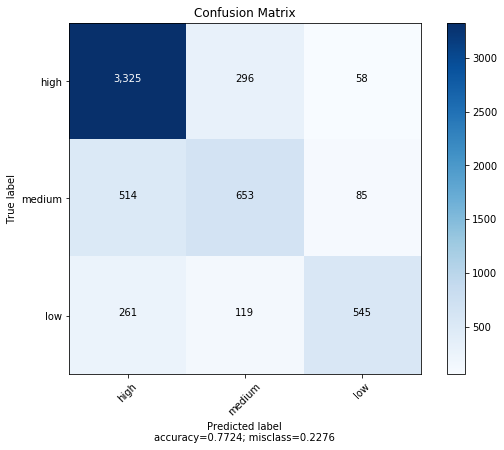

In [72]:
plot_confusion_matrix(cm           = np.array([[ 3325,  296, 58],
                                              [  514,  653,  85],
                                              [  261,  119, 545]]), 
                      normalize    = False,
                      target_names = ['high', 'medium', 'low'],
                      title        = "Confusion Matrix")

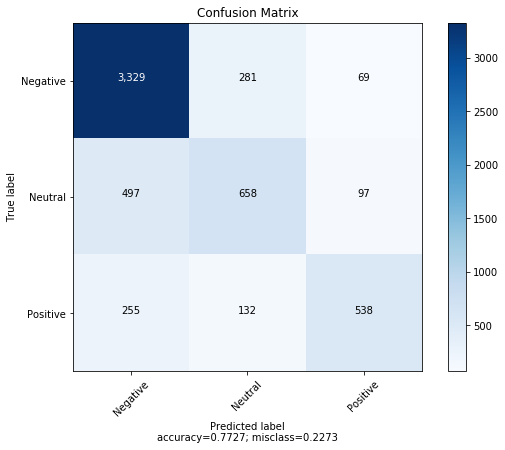

In [73]:
plot_confusion_matrix(cm           = np.array(c_matrix), 
                      normalize    = False,
                      target_names = ['Negative', 'Neutral', 'Positive'],
                      title        = "Confusion Matrix")

In [66]:
def print_scores():
    accuracy = (accuracy_score(y_test, y_pred_class))
    precision = (precision_score(y_test, y_pred_class))
    recall = (recall_score(y_test, y_pred_class))
    specificity = (str(c_matrix[0][0] / (c_matrix[0][0] + c_matrix[0][1])))
    f1 = (f1_score(y_test, y_pred_class))
    auc = (roc_auc_score(y_test, y_pred_class))
    
    print("accuracy: ", accuracy)
    print("precision: ", precision)
    print("recall (sensitivity): ", recall)
    print("specificity: ", specificity)
    print("f1: ", f1)
    print("auc: ", auc)
    return

In [ ]:
# Print scores and metrics.
print_scores()

## Random Forest

### Grid Search

In [428]:
start_time = time.clock()

# Random Forest - Grid Search

from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [40,50,60,70,80,90,100]}
rfc = GridSearchCV(RandomForestClassifier(), param_grid)
rfc = rfc.fit(X_train_tfidf, y_train)
print("Best parameters found by grid search:")
print(rfc.best_params_)
print("Best CV score:")
print(rfc.best_score_)

print('Runtime for fitting Random Forest: '+'%s seconds'% (time.clock() - start_time))

Best parameters found by grid search:
{'n_estimators': 70}
Best CV score:
0.7550091074681239
Runtime for fitting Random Forest: 189.62412710000353 seconds


In [ ]:
# To run feature importances, change GridSearch 'rfc' with best parameters.
rfc = RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=90)
rfc.fit(X_train_tfidf, y_train)

In [98]:
# Get accuracy scores on training and test sets.

accuracy_train = round(rfc.score(X_train_tfidf, y_train), 3)
accuracy_test = round(rfc.score(X_test_tfidf, y_test), 3)

print('Random Forest training accuracy score: ', accuracy_train)
print('Random Forest test accuracy score: ', accuracy_test)

Random Forest training accuracy score:  0.993
Random Forest test accuracy score:  0.757


In [99]:
# Print results.  Accuracy score on test set.  Cross validation on training set.

start_time = time.clock()

get_scores(rfc, X_test_tfidf, y_test)

print('Runtime for Random Forest 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 75.911% ± 0.521% 
 [0.76279863 0.74971559 0.76494024 0.75911162 0.75897436]
Accuracy score: 0.757



## Support Vector Machines

### Grid Search

In [100]:
start_time = time.clock()
    
# Support Vector Machine - Grid Search

# Create instance
svc = svm.SVC(kernel ='linear')

# other kernel was 'rbf'

# Specify hyperparameter range
C = [0.01, 0.1, 1, 10]

# Set hyperparameters 
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
svc_clf = GridSearchCV(svc, hyperparameters, cv=5)

# Run grid search
svc_results = svc_clf.fit(X_train_tfidf, y_train)

# Get results
print('C:', svc_results.best_estimator_.get_params()['C'])
print('Best score:', round(svc_results.best_score_, 3))
    
print('Runtime for SVM: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

C: 1
Best score: 0.766
Runtime for SVM: 143.83796620000066 seconds


In [101]:
# Get accuracy scores on training and test sets.

accuracy_train = round(svc_results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(svc_results.score(X_test_tfidf, y_test), 3)

print('Support Vector Machine training accuracy score: ', accuracy_train)
print('Support Vector Machine test accuracy score: ', accuracy_test)

Support Vector Machine training accuracy score:  0.898
Support Vector Machine test accuracy score:  0.772


In [102]:
start_time = time.clock()

# Print results

get_scores(svc_results, X_test_tfidf, y_test)

print('Runtime for SVM 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 76.639% ± 0.766% 
 [0.76279863 0.76678043 0.76323278 0.78075171 0.75840456]
Accuracy score: 0.772

Runtime for SVM 5-fold cross validation: 486.39637429999857 seconds


## Gradient Boosting

In [120]:
start_time = time.clock()

# Gradient Boosted Forest - Grid Search

# Create instance
gbc = ensemble.GradientBoostingClassifier(
    random_state=42
)

# Specify hyperparameter range
loss = ['deviance']
n_estimators = np.arange(100, 130, 5)
max_depth = np.arange(2, 5, 1)

# Set hyperparameters 
hyperparameters = dict(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    loss=loss 
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(gbc, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train_tfidf, y_train)

# Get results
print('n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Loss function: ', results.best_estimator_.get_params()['loss'])
print('Best score:', round(results.best_score_, 3))

print('Runtime for Gradient Boosting with: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

n estimators: 120
Max depth: 4
Loss function:  deviance
Best score: 0.723
Runtime for Gradient Boosting with: 1537.3679940000002 seconds


In [121]:
# Get accuracy scores on training and test sets.

accuracy_train = round(results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(results.score(X_test_tfidf, y_test), 3)

print('Gradient Boosting training accuracy score: ', accuracy_train)
print('Gradient Boosting test accuracy score: ', accuracy_test)

Gradient Boosting training accuracy score:  0.771
Gradient Boosting test accuracy score:  0.731


In [122]:
start_time = time.clock()

# Print results

get_scores(results, X_test_tfidf, y_test)

print('Runtime for Gradient Boosting 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 72.302% ± 0.401% 
 [0.721843   0.72127418 0.71883893 0.73063781 0.72250712]
Accuracy score: 0.731

Runtime for Gradient Boosting 5-fold cross validation: 6013.843744999991 seconds


# Test of Random Forest with class weights

## Normalize & stemmatize tweets

In [389]:
tweets_stems = []
for tweet in df['text']:
    w = normalizer_by_stemming(tweet)
    tweets_stems.append(w)

## Join stems together to vectorize 

In [390]:
s = ' ' 

joined_tweets_stems = []
for t in tweets_stems:
    joined_tweets_stems.append(s.join(t)) 

print(joined_tweets_stems[:4]) 

['said', 'plus youv ad commerci experi tacki', 'didnt today must mean need take anoth trip', 'realli aggress blast obnoxi entertain guest face littl recours']


## Vectorize joined tweets

In [599]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Creating Vectorizer and transforming data
cv2 = TfidfVectorizer(ngram_range=(1,1), stop_words='english', strip_accents='unicode')

#Applying the vectorizer
tweets_stems_tfidf = cv2.fit_transform(joined_tweets_stems)
print("Number of features: %d" % tweets_stems_tfidf.get_shape()[1])

Number of features: 11756


## Set features and target variable

In [647]:
Y = df.airline_sentiment
features = tweets_stems_tfidf

## Split TFIDF data into training and test sets.

In [648]:
# splitting into training and test sets
X_train, X_test = train_test_split(df, test_size=0.4, random_state=0)

## SMOTE training set to address imbalance

Since our classes are imbalanced, we should use the Synthetic Minority Oversampling Technique. This is done on the training set.

In [649]:
from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(features, Y, test_size=0.4, random_state=0)

## SMOTE training set to address imbalance

Since our classes are imbalanced, we should use the Synthetic Minority Oversampling Technique. This is done on the training set.

In [650]:
sm = SMOTE(random_state=42)
X_train_tfidf, y_train = sm.fit_sample(X_train_tfidf, y_train)
print('Original dataset shape: {}'.format(Counter(Y)))
print()
print('Resampled dataset shape: {}'.format(Counter(y_train)))

Original dataset shape: Counter({'negative': 9178, 'neutral': 3099, 'positive': 2363})

Resampled dataset shape: Counter({'negative': 5499, 'positive': 5499, 'neutral': 5499})


In [ ]:
Y2 = df.airline_sentiment

In [652]:
sm = SMOTE(random_state=42)
X_train_smote['airline_sentiment_confidence'] = sm.fit_sample(X_train['airline_sentiment_confidence'])

TypeError: fit_resample() missing 1 required positional argument: 'y'

## Random Forest

### Grid Search

In [651]:
start_time = time.clock()

# Random Forest - Grid Search

from sklearn.model_selection import GridSearchCV
# param_grid = {'n_estimators': [40,50,60,70,80,90,100]}

param_grid = {'n_estimators': [50,60,70]}
rfc_wt = GridSearchCV(RandomForestClassifier(), param_grid)
rfc_wt = rfc_wt.fit(X_train_tfidf, y_train, sample_weight = X_train['airline_sentiment_confidence'])

print("Best parameters found by grid search:")
print(rfc_wt.best_params_)
print("Best CV score:")
print(rfc_wt.best_score_)

print('Runtime for fitting Random Forest: '+'%s seconds'% (time.clock() - start_time))

ValueError: operands could not be broadcast together with shapes (8784,) (10998,) (8784,) 

In [616]:
# Get accuracy scores on training and test sets.

accuracy_train = round(rfc_wt.score(X_train_tfidf, y_train), 3)
accuracy_test = round(rfc_wt.score(X_test_tfidf, y_test), 3)

print('Random Forest training accuracy score: ', accuracy_train)
print('Random Forest test accuracy score: ', accuracy_test)

Random Forest training accuracy score:  0.993
Random Forest test accuracy score:  0.758


In [292]:
# Print results.  Accuracy score on test set.  Cross validation on training set.

start_time = time.clock()

get_scores(rfc, X_test_tfidf, y_test)

print('Runtime for Random Forest 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 74.444% ± 3.532% 
 [0.68606061 0.72575758 0.78727273 0.7669697  0.75614195]
Accuracy score: 0.694

Runtime for Random Forest 5-fold cross validation: 5.838920399997733 seconds


## Confusion Matrix - Random Forest

In [293]:
y_pred = rfc.predict(X_test_tfidf)

In [294]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[2752  765  162]
 [ 346  768  138]
 [ 188  192  545]]


## Classification Report - Random Forest

In [295]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.84      0.75      0.79      3679
     neutral       0.45      0.61      0.52      1252
    positive       0.64      0.59      0.62       925

   micro avg       0.69      0.69      0.69      5856
   macro avg       0.64      0.65      0.64      5856
weighted avg       0.72      0.69      0.70      5856



# Models with Bigrams

In [640]:
from nltk import ngrams
def ngrams_2(initial_list):
    bigrams = [''.join(t) for t in list(zip(initial_list, initial_list[1:]))]
    return bigrams

df['bigrams_stem'] = df.normalized_tweet_stem.apply(ngrams_2)
df[['bigrams_stem']].head()

,bigrams_stem
0,[]
1,"[plusyouv, youvad, adcommerci, commerciexperi, experitacki]"
2,"[didnttoday, todaymust, mustmean, meanneed, needtake, takeanoth, anothtrip]"
3,"[realliaggress, aggressblast, blastobnoxi, obnoxientertain, entertainguest, guestface, facelittl, littlrecours]"
4,"[reallibig, bigbad, badthing]"


## Normalize & stemmatize tweets

In [646]:
tweets_stems_bigrams = []
for w in df['bigrams_stem']:
    tweets_stems_bigrams.append(w)

## Join stems together to vectorize 

In [643]:
s = ' ' 

joined_tweets_stems_bigrams = []
for t in tweets_stems_bigrams:
    joined_tweets_stems_bigrams.append(s.join(t)) 

print(joined_tweets_stems_bigrams[:4]) 

['', 'plusyouv youvad adcommerci commerciexperi experitacki', 'didnttoday todaymust mustmean meanneed needtake takeanoth anothtrip', 'realliaggress aggressblast blastobnoxi obnoxientertain entertainguest guestface facelittl littlrecours']


## Vectorize joined tweets

In [645]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Creating Vectorizer and transforming data
cv3 = TfidfVectorizer(ngram_range=(1,1), stop_words='english', strip_accents='unicode')

#Applying the vectorizer
tweets_stems_bigrams_tfidf = cv3.fit_transform(joined_tweets_stems_bigrams)
print("Number of features: %d" % tweets_stems_bigrams_tfidf.get_shape()[1])

Number of features: 80302


## Set features and target variable

In [392]:
Y = df.airline_sentiment
features = tweets_stems_tfidf

## Split TFIDF data into training and test sets.

In [393]:
# splitting into training and test sets
X_train, X_test = train_test_split(tweets, test_size=0.4, random_state=0)

In [394]:
from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(features, Y, test_size=0.4, random_state=0)

## View content of cells.

# Run Models with stems (20% test size)

In [663]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df['normalized_tweet_stem'] = df.text.apply(normalizer_by_stemming)
df[['text','normalized_tweet_stem']].head()

,text,normalized_tweet_stem
0,@VirginAmerica What @dhepburn said.,[said]
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[plus, youv, ad, commerci, experi, tacki]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[didnt, today, must, mean, need, take, anoth, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[realli, aggress, blast, obnoxi, entertain, guest, face, littl, recours]"
4,@VirginAmerica and it's a really big bad thing about it,"[realli, big, bad, thing]"


## View content of cells.

In [664]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df[['text','normalized_tweet_stem']][16:30]

,text,normalized_tweet_stem
16,@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo,"[excit, first, cross, countri, flight, lax, mco, ive, heard, noth, great, thing, virgin, america, 29daystogo]"
17,@VirginAmerica I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!,"[flew, nyc, sfo, last, week, couldnt, fulli, sit, seat, due, two, larg, gentleman, either, side, help]"
18,I ❤️ flying @VirginAmerica. ☺️👍,[fli]
19,@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.,"[know, would, amaz, awesom, bosfll, pleas, want, fli]"
20,@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???,"[first, fare, may, three, time, carrier, seat, avail, select]"
21,@VirginAmerica I love this graphic. http://t.co/UT5GrRwAaA,"[love, graphic]"
22,@VirginAmerica I love the hipster innovation. You are a feel good brand.,"[love, hipster, innov, feel, good, brand]"
23,@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?,"[make, bosgtla, non, stop, perman, anytim, soon]"
24,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,"[guy, mess, seat, reserv, seat, friend, guy, gave, seat, away, want, free, internet]"
25,@VirginAmerica status match program. I applied and it's been three weeks. Called and emailed with no response.,"[status, match, program, appli, three, week, call, email, respons]"


## Normalize & stemmatize tweets

In [665]:
tweets_stems = []
for tweet in df['text']:
    w = normalizer_by_stemming(tweet)
    tweets_stems.append(w)

## Join stems together to vectorize 

In [666]:
s = ' ' 

joined_tweets_stems = []
for t in tweets_stems:
    joined_tweets_stems.append(s.join(t)) 

print(joined_tweets_stems[:4]) 

['said', 'plus youv ad commerci experi tacki', 'didnt today must mean need take anoth trip', 'realli aggress blast obnoxi entertain guest face littl recours']


## Vectorize joined tweets

In [667]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Creating Vectorizer and transforming data
cv2 = TfidfVectorizer(ngram_range=(1,1), stop_words='english', strip_accents='unicode')

#Applying the vectorizer
tweets_stems_tfidf = cv2.fit_transform(joined_tweets_stems)
print("Number of features: %d" % tweets_stems_tfidf.get_shape()[1])

Number of features: 11756


## Set features and target variable

In [668]:
Y = df.airline_sentiment
features = tweets_stems_tfidf

## Split TFIDF data into training and test sets.

In [669]:
# splitting into training and test sets
X_train, X_test = train_test_split(tweets, test_size=0.2, random_state=0)

In [670]:
from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=0)

In [671]:
#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of tweets
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per tweet
tfidf_of_stems_bytweet = [{} for _ in range(0,n)]
#List of features
terms = cv2.get_feature_names()
#for each tweet, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_of_stems_bytweet[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original tweet:', X_train[5])
print('Tf_idf vector:', tfidf_of_stems_bytweet[5])    


Original tweet: ['222mdw', '2', 'san', 'flt', '1687', 'attendant', 'melissa', 'awesome', 'fast', 'smiling', 'great', 'weather', 'cancelled', 'flight', 'day', 'b4', 'welcome']
Tf_idf vector: {'melissa': 0.36177657257114615, '1687': 0.3469572811122235, '222mdw': 0.36177657257114615, 'smile': 0.2933643184505015, 'fast': 0.28147049749558845, 'b4': 0.2857753343345773, 'attend': 0.20277883052861573, 'day': 0.1585399434446937, 'welcom': 0.2758364643635889, 'flt': 0.2072905762007051, 'san': 0.2288269095053227, 'weather': 0.17925779659568178, 'cancel': 0.134203694321843, 'awesom': 0.2112304190229616, 'great': 0.17674444568118844, 'flight': 0.08501954828427777}


## Naive Bayes

In [672]:
start_time = time.clock()

# Naive Bayes 

# Import model
from sklearn.naive_bayes import MultinomialNB

# Create instance
clf = MultinomialNB()

# Fit training data
clf.fit(X_train_tfidf, y_train)

print('Runtime for fitting Naive Bayes: '+'%s seconds'% (time.clock() - start_time))

Runtime for fitting Naive Bayes: 0.03672049997840077 seconds


## Check accuracy of model

In [673]:
# Get accuracy scores on training and test sets.

accuracy_train = round(clf.score(X_train_tfidf, y_train), 3)
accuracy_test = round(clf.score(X_test_tfidf, y_test), 3)

print('Naive Bayes training accuracy score: ', accuracy_train)
print('Naive Bayes test accuracy score: ', accuracy_test)

Naive Bayes training accuracy score:  0.73
Naive Bayes test accuracy score:  0.69


## Cross Validation

In [82]:
start_time = time.clock()

# Print results

get_scores(clf, X_test_tfidf, y_test)

print('Runtime for Naive Bayes cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 66.507% ± 0.393% 
 [0.66382253 0.66609784 0.66021628 0.67198178 0.66324786]
Accuracy score: 0.669

Runtime for Naive Bayes cross validation: 0.039084600000023784 seconds


In [83]:
y_pred = clf.predict(X_test_tfidf)

In [84]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.6690573770491803


In [85]:
c_matrix = metrics.confusion_matrix(y_test, y_pred)
print(c_matrix)

[[3662   16    1]
 [1093  135   24]
 [ 780   24  121]]


In [86]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.66      1.00      0.79      3679
     neutral       0.77      0.11      0.19      1252
    positive       0.83      0.13      0.23       925

   micro avg       0.67      0.67      0.67      5856
   macro avg       0.75      0.41      0.40      5856
weighted avg       0.71      0.67      0.58      5856



## Logistic Regression

### Grid Search

In [91]:
start_time = time.clock()

# Create a new instance for regularization
logit = LogisticRegression()

# Specify regularization penalties
penalty = ['l1', 'l2']

# Specify regularization hyperparameter range
C = np.logspace(1, 15, 2)

# Set hyperparameters 
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logit, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train_tfidf, y_train)

# Get results
print('Best Penalty:', results.best_estimator_.get_params()['penalty'])
print('Best C:', results.best_estimator_.get_params()['C'])
print('Best cross validation score:', round(results.best_score_, 3))

print('Runtime for fitting Logistic Regression: '+'%s seconds'% (time.clock() - start_time))

Best Penalty: l2
Best C: 10.0
Best cross validation score: 0.768
Runtime for fitting Logistic Regression: 31.41898509999919 seconds


In [92]:
# Get accuracy scores on training and test sets.

print('Logistic regression training accuracy score: ', round(results.score(X_train_tfidf, y_train), 3))
print('Logistic regression test accuracy score: ', round(results.score(X_test_tfidf, y_test), 3))

Logistic regression training accuracy score:  0.946
Logistic regression test accuracy score:  0.773


In [93]:
start_time = time.clock()

# Print results.  Accuracy score on test set.  Cross validation on training set.

get_scores(results, X_test_tfidf, y_test)

print('Runtime for Logistic Regression cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 76.810% ± 0.525% 
 [0.76393629 0.76222981 0.7689243  0.77733485 0.76809117]
Accuracy score: 0.773

Runtime for Logistic Regression cross validation: 128.1062170999976 seconds


## Confusion Matrix - Logistic Regression

In [94]:
# Examine the class distribution of the testing set.
y_test.value_counts()

-1    3679
 0    1252
 1    925 
Name: airline_sentiment, dtype: int64

In [95]:
y_pred_class = results.predict(X_test_tfidf)

In [96]:
c_matrix = metrics.confusion_matrix(y_test, y_pred_class)
print(c_matrix)

[[3329  281   69]
 [ 497  658   97]
 [ 255  132  538]]


In [71]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

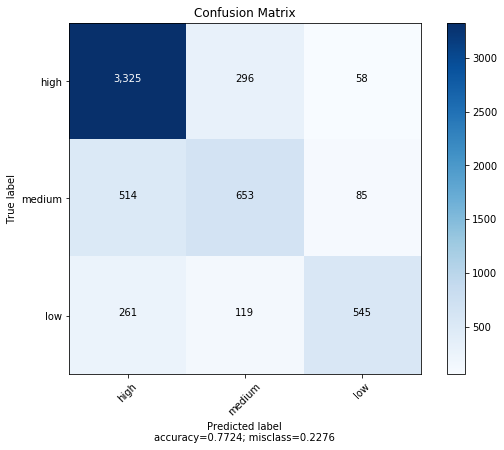

In [72]:
plot_confusion_matrix(cm           = np.array([[ 3325,  296, 58],
                                              [  514,  653,  85],
                                              [  261,  119, 545]]), 
                      normalize    = False,
                      target_names = ['high', 'medium', 'low'],
                      title        = "Confusion Matrix")

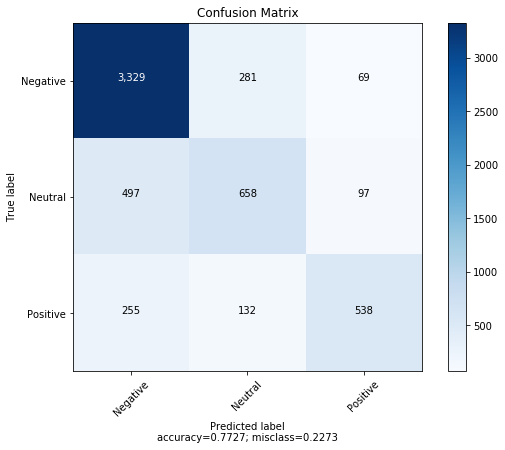

In [73]:
plot_confusion_matrix(cm           = np.array(c_matrix), 
                      normalize    = False,
                      target_names = ['Negative', 'Neutral', 'Positive'],
                      title        = "Confusion Matrix")

In [66]:
def print_scores():
    accuracy = (accuracy_score(y_test, y_pred_class))
    precision = (precision_score(y_test, y_pred_class))
    recall = (recall_score(y_test, y_pred_class))
    specificity = (str(c_matrix[0][0] / (c_matrix[0][0] + c_matrix[0][1])))
    f1 = (f1_score(y_test, y_pred_class))
    auc = (roc_auc_score(y_test, y_pred_class))
    
    print("accuracy: ", accuracy)
    print("precision: ", precision)
    print("recall (sensitivity): ", recall)
    print("specificity: ", specificity)
    print("f1: ", f1)
    print("auc: ", auc)
    return

In [ ]:
# Print scores and metrics.
print_scores()

## Random Forest

### Grid Search

In [87]:
start_time = time.clock()

# Random Forest - Grid Search

from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [40,50,60,70,80,90,100]}
rfc = GridSearchCV(RandomForestClassifier(), param_grid)
rfc = rfc.fit(X_train_tfidf, y_train)
print("Best parameters found by grid search:")
print(rfc.best_params_)
print("Best CV score:")
print(rfc.best_score_)

print('Runtime for fitting Random Forest: '+'%s seconds'% (time.clock() - start_time))

Best parameters found by grid search:
{'n_estimators': 100}
Best CV score:
0.7556921675774135
Runtime for fitting Random Forest: 196.51096819999998 seconds


In [ ]:
# To run feature importances, change GridSearch 'rfc' with best parameters.
rfc = RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=90)
rfc.fit(X_train_tfidf, y_train)

In [98]:
# Get accuracy scores on training and test sets.

accuracy_train = round(rfc.score(X_train_tfidf, y_train), 3)
accuracy_test = round(rfc.score(X_test_tfidf, y_test), 3)

print('Random Forest training accuracy score: ', accuracy_train)
print('Random Forest test accuracy score: ', accuracy_test)

Random Forest training accuracy score:  0.993
Random Forest test accuracy score:  0.757


In [99]:
# Print results.  Accuracy score on test set.  Cross validation on training set.

start_time = time.clock()

get_scores(rfc, X_test_tfidf, y_test)

print('Runtime for Random Forest 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time))

Cross validation results: 75.911% ± 0.521% 
 [0.76279863 0.74971559 0.76494024 0.75911162 0.75897436]
Accuracy score: 0.757



## Support Vector Machines

### Grid Search

In [100]:
start_time = time.clock()
    
# Support Vector Machine - Grid Search

# Create instance
svc = svm.SVC(kernel ='linear')

# other kernel was 'rbf'

# Specify hyperparameter range
C = [0.01, 0.1, 1, 10]

# Set hyperparameters 
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
svc_clf = GridSearchCV(svc, hyperparameters, cv=5)

# Run grid search
svc_results = svc_clf.fit(X_train_tfidf, y_train)

# Get results
print('C:', svc_results.best_estimator_.get_params()['C'])
print('Best score:', round(svc_results.best_score_, 3))
    
print('Runtime for SVM: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

C: 1
Best score: 0.766
Runtime for SVM: 143.83796620000066 seconds


In [101]:
# Get accuracy scores on training and test sets.

accuracy_train = round(svc_results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(svc_results.score(X_test_tfidf, y_test), 3)

print('Support Vector Machine training accuracy score: ', accuracy_train)
print('Support Vector Machine test accuracy score: ', accuracy_test)

Support Vector Machine training accuracy score:  0.898
Support Vector Machine test accuracy score:  0.772


In [102]:
start_time = time.clock()

# Print results

get_scores(svc_results, X_test_tfidf, y_test)

print('Runtime for SVM 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 76.639% ± 0.766% 
 [0.76279863 0.76678043 0.76323278 0.78075171 0.75840456]
Accuracy score: 0.772

Runtime for SVM 5-fold cross validation: 486.39637429999857 seconds


## Gradient Boosting

In [655]:
start_time = time.clock()

# Gradient Boosted Forest - Grid Search

# Create instance
gbc = ensemble.GradientBoostingClassifier(
    random_state=42
)

# Specify hyperparameter range
loss = ['deviance']
n_estimators = np.arange(100, 130, 5)
max_depth = np.arange(2, 5, 1)

# Set hyperparameters 
hyperparameters = dict(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    loss=loss 
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(gbc, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train_tfidf, y_train)

# Get results
print('n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Loss function: ', results.best_estimator_.get_params()['loss'])
print('Best score:', round(results.best_score_, 3))

print('Runtime for Gradient Boosting with: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

KeyboardInterrupt: 

In [121]:
# Get accuracy scores on training and test sets.

accuracy_train = round(results.score(X_train_tfidf, y_train), 3)
accuracy_test = round(results.score(X_test_tfidf, y_test), 3)

print('Gradient Boosting training accuracy score: ', accuracy_train)
print('Gradient Boosting test accuracy score: ', accuracy_test)

Gradient Boosting training accuracy score:  0.771
Gradient Boosting test accuracy score:  0.731


In [122]:
start_time = time.clock()

# Print results

get_scores(results, X_test_tfidf, y_test)

print('Runtime for Gradient Boosting 5-fold cross validation: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Cross validation results: 72.302% ± 0.401% 
 [0.721843   0.72127418 0.71883893 0.73063781 0.72250712]
Accuracy score: 0.731

Runtime for Gradient Boosting 5-fold cross validation: 6013.843744999991 seconds
